In [1]:

import os
import sys
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import seaborn as sns
from tqdm.auto import tqdm
from scipy.signal import butter, sosfiltfilt

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.utils.k_folds_creator import KFoldCreator
from src.utils.utils import get_models_save_path
from src.utils.constants import Constants 
from src.datasets.eeg_dataset_montage import EEGDatasetMontage





2025-12-10 23:25:54,401 :: root :: INFO :: Initialising Utils
2025-12-10 23:25:54,431 :: root :: INFO :: Initialising Datasets
2025-12-10 23:25:54,433 :: root :: INFO :: Initialising Models


Skipping module cbramod_dataset due to missing dependency: No module named 'mne'


/home/maiko/miniconda3/envs/aicomp_312/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/maiko/miniconda3/envs/aicomp_312/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happ

In [2]:

class CFG:
    seed = 42
    n_splits = 5
    data_path = '../data/'

    model_name = 'GRUConvNodeAttentionModel'
    hidden_units = 256
    num_layers = 1
    target_size = 6 
    num_cnn_blocks = 4 
    num_channels = 19
    
    sampling_rate = 200 
    downsample_factor = 1
    
    batch_size = 32
    num_workers = 8
    dropout = 0.4
    use_inception = True

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(CFG.seed)
TARGETS = ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]
# Short names for plotting
TARGET_LABELS = ["Seizure", "LPD", "GPD", "LRDA", "GRDA", "Other"] 

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {DEVICE}")


class AttentionPool(nn.Module):
    def __init__(self, in_features, hidden_dim):
        super().__init__()
        self.attention_net = nn.Sequential(
            nn.Linear(in_features, hidden_dim), 
            nn.Tanh(), 
            nn.Linear(hidden_dim, 1, bias=False)
        )

    def forward(self, x, return_weights=False):
        energy = self.attention_net(x)
        weights = F.softmax(energy, dim=1)
        context_vector = torch.sum(x * weights, dim=1)
        if return_weights:
            return context_vector, weights
        return context_vector


class ResNet1DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=7, stride=stride, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=7, stride=1, padding=3, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.shortcut = nn.Sequential()
        if stride > 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
            )
        self.act2 = nn.ReLU()

    def forward(self, x):
        out = self.act1(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.act2(out)
        return out


class NodeAttentionModel(nn.Module):
    def __init__(
        self,
        num_nodes,
        node_embed_size,
        hidden_size,
        num_layers,
        num_classes,
        num_cnn_blocks=4,
        dropout=0.2,
        use_inception=True,
    ):
        super().__init__()
        self.num_nodes = num_nodes
        self.node_embed_size = node_embed_size
        self.use_inception = use_inception

        channels = [32, 64, 64, 128, 128]

        self.stem = nn.Sequential(
            nn.Conv1d(1, channels[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(channels[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),
        )

        layers = []
        for i in range(num_cnn_blocks):
            in_channels = channels[i]
            out_channels = channels[i + 1]
            current_stride = 2 if i < 3 else 1

            if self.use_inception:
                layers.append(ResNet1DBlock(in_channels, out_channels, stride=current_stride))
            else:
                layers.append(
                    nn.Sequential(
                        nn.Conv1d(in_channels, out_channels, kernel_size=7, stride=current_stride, padding=3),
                        nn.BatchNorm1d(out_channels),
                        nn.ReLU(),
                    )
                )

        self.cnn_frontend = nn.Sequential(*layers)

        gru_input_size = channels[num_cnn_blocks]

        self.gru = nn.GRU(
            input_size=gru_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )

        gru_output_features = hidden_size * 2
        self.temporal_pool = AttentionPool(gru_output_features, gru_output_features // 2)
        self.node_embedding_head = nn.Linear(gru_output_features, node_embed_size)
        self.pos_encoding = nn.Parameter(torch.randn(1, num_nodes, node_embed_size))
        self.attn_layer_norm1 = nn.LayerNorm(node_embed_size)
        self.mha = nn.MultiheadAttention(embed_dim=node_embed_size, num_heads=4, dropout=0.1, batch_first=True)
        self.attn_layer_norm2 = nn.LayerNorm(node_embed_size)
        self.fc = nn.Sequential(
            nn.Linear(node_embed_size, node_embed_size * 2), nn.ReLU(), nn.Linear(node_embed_size * 2, node_embed_size)
        )
        self.node_pool = AttentionPool(node_embed_size, node_embed_size)
        self.classifier = nn.Sequential(
            nn.Linear(node_embed_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes),
        )

    def forward(self, x, return_attention=False):
        B, S, N = x.shape
        x = x.permute(0, 2, 1)
        x = x.reshape(B * N, 1, S)

        x = self.stem(x)
        x_cnn = self.cnn_frontend(x)
        x_cnn = x_cnn.permute(0, 2, 1)

        gru_out, _ = self.gru(x_cnn)

        if return_attention:
            x_pooled, temp_weights = self.temporal_pool(gru_out, return_weights=True)
        else:
            x_pooled = self.temporal_pool(gru_out)
            
        x_embedded = self.node_embedding_head(x_pooled)
        node_embeddings = x_embedded.reshape(B, N, -1)
        x = node_embeddings + self.pos_encoding
        x_norm = self.attn_layer_norm1(x)
        
        attn_out, mha_weights = self.mha(x_norm, x_norm, x_norm, need_weights=True)
        x = x + attn_out
        x_norm = self.attn_layer_norm2(x)
        fc_out = self.fc(x_norm)
        x = x + fc_out
        
        if return_attention:
            pooled_output, node_weights = self.node_pool(x, return_weights=True)
        else:
            pooled_output = self.node_pool(x)
            
        output = self.classifier(pooled_output)
        
        if return_attention:
            return output, {
                'temporal_weights': temp_weights,
                'mha_weights': mha_weights,
                'node_weights': node_weights
            }
        
        return output


Using Device: cuda


In [ ]:
MONTAGE_GROUPS = {
    "Left Temporal": ["Fp1-F7", "F7-T3", "T3-T5", "T5-O1"],
    "Right Temporal": ["Fp2-F8", "F8-T4", "T4-T6", "T6-O2"],
    "Left Parasagittal": ["Fp1-F3", "F3-C3", "C3-P3", "P3-O1"],
    "Right Parasagittal": ["Fp2-F4", "F4-C4", "C4-P4", "P4-O2"],
    "Midline": ["Fz-Cz", "Cz-Pz"],
    "EKG": ["EKG"]
}

CHANNEL_NAMES = []
GROUP_INDICES = {} 
current_idx = 0
for group_name, channels in MONTAGE_GROUPS.items():
    start = current_idx
    CHANNEL_NAMES.extend(channels)
    end = current_idx + len(channels)
    GROUP_INDICES[group_name] = list(range(start, end))
    current_idx = end

def get_1020_positions():
    return {
        'Fp1': (-0.3, 0.85), 'Fp2': (0.3, 0.85), 'F7': (-0.75, 0.55), 'F3': (-0.4, 0.55), 
        'Fz': (0, 0.55), 'F4': (0.4, 0.55), 'F8': (0.75, 0.55), 'T3': (-0.85, 0), 
        'C3': (-0.45, 0), 'Cz': (0, 0), 'C4': (0.45, 0), 'T4': (0.85, 0), 
        'T5': (-0.75, -0.55), 'P3': (-0.4, -0.55), 'Pz': (0, -0.55), 'P4': (0.4, -0.55), 
        'T6': (0.75, -0.55), 'O1': (-0.3, -0.85), 'O2': (0.3, -0.85)
    }

def get_montage_centroids(channel_names):
    coords = get_1020_positions()
    centroids = {}
    for i, name in enumerate(channel_names):
        if name == "EKG": continue
        try:
            start, end = name.split('-')
            if start in coords and end in coords:
                x1, y1 = coords[start]; x2, y2 = coords[end]
                centroids[i] = ((x1 + x2) / 2, (y1 + y2) / 2)
        except: continue
    return centroids

def draw_head_outline(ax):
    circle = patches.Circle((0, 0), 1.0, edgecolor='black', facecolor='none', linewidth=2, alpha=0.5)
    ax.add_patch(circle)
    ax.plot([-0.1, 0, 0.1], [0.95, 1.05, 0.95], color='black', linewidth=2)
    ax.plot([-1.02, -1.05, -1.02], [0.1, 0, -0.1], color='black')
    ax.plot([1.02, 1.05, 1.02], [0.1, 0, -0.1], color='black')
    ax.set_xlim(-1.2, 1.2); ax.set_ylim(-1.2, 1.2); ax.axis('off')

def plot_node_importance_map(ax, channel_names, weights):
    draw_head_outline(ax)
    coords = get_1020_positions()
    w_min, w_max = weights.min(), weights.max()
    cmap = plt.cm.Reds
    for name, weight in zip(channel_names, weights):
        if name == "EKG": continue
        try:
            start, end = name.split('-')
            if start in coords and end in coords:
                x1, y1 = coords[start]; x2, y2 = coords[end]
                norm_w = (weight - w_min) / (w_max - w_min + 1e-9)
                ax.plot([x1, x2], [y1, y2], color=cmap(norm_w), linewidth=1.5+(norm_w*6), alpha=0.4+(norm_w*0.6))
                ax.scatter([x1, x2], [y1, y2], color='black', s=10)
        except: continue
    ax.set_title("Topographic Importance", fontsize=16, fontweight='bold')


def plot_spatial_connectivity_map(ax, channel_names, attention_matrix, node_importance):
    """ 
    Plots:
    1. NODES as straight lines (electrode pairs) colored by Importance (Reds).
    2. CONNECTIVITY as curved arcs between the centers of those lines (Blues).
    """
    draw_head_outline(ax)
    coords = get_1020_positions()
    centroids = get_montage_centroids(channel_names)
    

    w_min, w_max = node_importance.min(), node_importance.max()
    if w_max == w_min: w_max += 1e-9
    node_cmap = plt.cm.Reds
    
    for name, weight in zip(channel_names, node_importance):
        if name == "EKG": continue
        try:
            start, end = name.split('-')
            if start in coords and end in coords:
                x1, y1 = coords[start]
                x2, y2 = coords[end]
                
                norm_w = (weight - w_min) / (w_max - w_min)
                color = node_cmap(norm_w)
                
                lw = 2.0 + (norm_w * 5.0)
                alpha = 0.5 + (norm_w * 0.5)
                
                ax.plot([x1, x2], [y1, y2], color=color, linewidth=lw, alpha=alpha, zorder=2)
                
                ax.scatter([x1, x2], [y1, y2], color='black', s=15, zorder=2)
        except ValueError: continue

    importance_grid = np.outer(node_importance, node_importance)
    weighted_adj = attention_matrix * importance_grid

    edges = []
    flat_weights = weighted_adj.flatten()
    percentile = 95
    threshold = np.percentile(flat_weights, percentile)
    max_val = flat_weights.max()
    if max_val <= threshold: max_val = threshold + 1e-9
    
    num_channels = len(channel_names)
    for i in range(num_channels):
        for j in range(num_channels):
            if i == j: continue 
            
            weight = weighted_adj[i, j]
            
            if weight > threshold and i in centroids and j in centroids:
                edges.append((weight, i, j))

    edges.sort(key=lambda x: x[0])
    
    conn_cmap = plt.cm.Blues
    
    for weight, i, j in edges:
        posA = centroids[i]
        posB = centroids[j]
        
        norm_w = (weight - threshold) / (max_val - threshold)

        color = conn_cmap(0.4 + (0.6 * norm_w)) 
        lw = 1.0 + (norm_w * 3.0)
        alpha = 0.6 + (norm_w * 0.4)

        connection_style = f"arc3,rad=0.3" 
        
        arrow = patches.FancyArrowPatch(
            posA, posB, 
            connectionstyle=connection_style,
            color=color,
            linewidth=lw,
            alpha=alpha,
            arrowstyle='->', 
            mutation_scale=15,
            zorder=3 
        )
        ax.add_patch(arrow)

    for i, (cx, cy) in centroids.items():
        name = channel_names[i]

        ax.text(cx, cy, name, fontsize=7, ha='center', va='center', 
                color='black', fontweight='bold', zorder=4,
                bbox=dict(boxstyle="square,pad=0.1", fc="white", ec="none", alpha=0.7))

    ax.set_title(f"Importance-Weighted Connectivity (Top {100-percentile}%)\n(Attention $\\times$ Node Importance)", fontsize=16, fontweight='bold')

def interpret_sample(model, dataset, sample_index, title_prefix=""):
    try: signal, label = dataset[sample_index]
    except: return
    signal = signal.unsqueeze(0).to(DEVICE)
    target = label.numpy()
    
    model.eval()
    with torch.no_grad(): output, attn_dict = model(signal, return_attention=True)
    
    probs = torch.softmax(output, dim=1).cpu().numpy()[0]
    pred_idx, true_idx = np.argmax(probs), np.argmax(target)
    
    mha_w = attn_dict['mha_weights'][0].cpu().numpy()
    node_w = attn_dict['node_weights'].squeeze(-1).cpu().numpy()[0]
    
    # --- FIGURE 1: PREDICTION DISTRIBUTIONS (Overlapping) ---
    fig1 = plt.figure(figsize=(10, 5))
    plt.title(f"{title_prefix}\nSample #{sample_index} | True: {TARGETS[true_idx]} | Pred: {TARGETS[pred_idx]}", fontsize=14)
    
    x_pos = np.arange(len(TARGET_LABELS))
    
    plt.bar(x_pos, target, color='#1f77b4', alpha=0.5, label='Ground Truth (Votes)', width=0.6)
    plt.bar(x_pos, probs, color='#ff7f0e', alpha=0.5, label='Model Prediction', width=0.6)
    
    plt.xticks(x_pos, TARGET_LABELS, fontsize=11)
    plt.ylabel("Probability / Vote Fraction")
    plt.legend(loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.show()

    # --- FIGURE 2: NODE IMPORTANCE ---
    fig2 = plt.figure(figsize=(20, 9))
    gs2 = gridspec.GridSpec(1, 2, width_ratios=[1, 1.2], wspace=0.1)
    plot_node_importance_map(plt.subplot(gs2[0]), CHANNEL_NAMES, node_w)
    
    ax_bar = plt.subplot(gs2[1])
    group_colors = {"Left Temporal": "#1f77b4", "Right Temporal": "#ff7f0e", "Left Parasagittal": "#2ca02c", "Right Parasagittal": "#d62728", "Midline": "#9467bd", "EKG": "#8c564b"}
    y_pos, y_ticks, y_labels = 0, [], []
    for group_name in list(MONTAGE_GROUPS.keys())[::-1]:
        indices = GROUP_INDICES[group_name]
        weights = node_w[indices]
        ax_bar.barh(y=np.arange(y_pos, y_pos+len(weights)), width=weights, color=group_colors[group_name], label=group_name)
        for i, name in enumerate([CHANNEL_NAMES[x] for x in indices]):
            y_ticks.append(y_pos + i); y_labels.append(name)
        y_pos += len(weights) + 1
    ax_bar.set_yticks(y_ticks); ax_bar.set_yticklabels(y_labels, fontsize=10)
    ax_bar.set_title("Channel Weights (Grouped)", fontsize=16, fontweight='bold')
    ax_bar.legend(loc='lower right')
    plt.show()

    # --- FIGURE 3: SPATIAL CONNECTIVITY ---
    fig3 = plt.figure(figsize=(22, 10)) 
    gs3 = gridspec.GridSpec(1, 2, width_ratios=[1, 1.2], wspace=0.1)
    plot_spatial_connectivity_map(plt.subplot(gs3[0]), CHANNEL_NAMES, mha_w, node_w)
    
    ax_matrix = plt.subplot(gs3[1])
    

    sns.heatmap(mha_w, ax=ax_matrix, cmap="magma", square=True, cbar=True, 
                xticklabels=CHANNEL_NAMES, yticklabels=CHANNEL_NAMES)
    
    ax_matrix.set_title("Full Unweighted Connection Attention Matrix", fontsize=16, fontweight='bold')
    ax_matrix.set_xlabel("Source Channel", fontsize=12)
    ax_matrix.set_ylabel("Target Channel", fontsize=12)
    

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    
    plt.show()

import seaborn as sns

def plot_kld_distribution(df):
    """
    Plots the distribution of Kullback-Leibler Divergence scores.
    """
    clean_df = df.dropna(subset=['kld_score'])
    
    plt.figure(figsize=(20, 12))
    
    # --- Plot 1: Overall Histogram ---
    plt.subplot(2, 2, 1)
    sns.histplot(clean_df['kld_score'], bins=50, kde=True, color='teal')
    plt.title(f"Overall KLD Score Distribution\n(Mean: {clean_df['kld_score'].mean():.4f})", fontsize=14)
    plt.xlabel("KL Divergence (Lower is Better)")
    plt.ylabel("Count")
    
    # --- Plot 2: Boxplot by Class ---
    plt.subplot(2, 2, 2)
    sns.boxplot(data=clean_df, x='expert_consensus', y='kld_score', palette="viridis")
    plt.title("KLD Score by Expert Consensus", fontsize=14)
    plt.xlabel("Class")
    plt.ylabel("KL Divergence")
    plt.xticks(rotation=45)
    
    # --- Plot 3: KDE (Density) by Class ---
    plt.subplot(2, 1, 2)
    sns.kdeplot(data=clean_df, x='kld_score', hue='expert_consensus', fill=True, alpha=0.3, palette="tab10", common_norm=False)
    plt.title("Error Density by Class (Normalized)", fontsize=14)
    plt.xlabel("KL Divergence")
    plt.xlim(0, clean_df['kld_score'].quantile(0.95)) 
    
    plt.tight_layout()
    plt.show()
    
    print("\nSummary Statistics by Class:")
    print(clean_df.groupby('expert_consensus')['kld_score'].describe()[['count', 'mean', 'std', 'max']].sort_values(by='mean', ascending=False))


from sklearn.metrics import confusion_matrix

def plot_soft_target_confusion_matrix(model, dataset, device, normalize=None):
    """
    Generates a Confusion Matrix by converting soft targets/predictions 
    to hard labels using Argmax (Highest Probability).
    
    Args:
        normalize: 'true' (rows sum to 1), 'pred' (cols sum to 1), 'all', or None
    """
    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)
    
    all_preds = []
    all_targets = []
    
    print(f"Generating Confusion Matrix on {len(dataset)} samples...")
    model.eval()
    
    with torch.no_grad():
        for signals, labels in tqdm(loader, desc="Running Inference"):
            signals = signals.to(device)
            labels = labels.to(device)
            
            outputs = model(signals)
            probs = torch.softmax(outputs, dim=1)
            
            pred_classes = torch.argmax(probs, dim=1).cpu().numpy()
            target_classes = torch.argmax(labels, dim=1).cpu().numpy()
            
            all_preds.extend(pred_classes)
            all_targets.extend(target_classes)

    cm = confusion_matrix(all_targets, all_preds, normalize=normalize)

    plt.figure(figsize=(10, 8))
    
    fmt = '.2f' if normalize else 'd'
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', 
                xticklabels=TARGET_LABELS, 
                yticklabels=TARGET_LABELS)
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label (Expert Consensus)')
    plt.title(f'Confusion Matrix (Normalize={normalize})')
    plt.show()

from sklearn.metrics import top_k_accuracy_score

def analyze_soft_predictions(model, dataset, device):
    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)
    
    all_probs = []
    all_targets = []
    
    print(f"Running Inference for Soft Analysis...")
    model.eval()
    
    with torch.no_grad():
        for signals, labels in tqdm(loader):
            signals = signals.to(device)
            labels = labels.to(device)
            
            outputs = model(signals)
            probs = torch.softmax(outputs, dim=1)
            
            all_probs.append(probs.cpu().numpy())
            all_targets.append(torch.argmax(labels, dim=1).cpu().numpy()) # Hard True Labels
            
    all_probs = np.concatenate(all_probs)
    all_targets = np.concatenate(all_targets)
    
    # --- PLOT 1: SOFT CONFUSION MATRIX ---
    soft_cm = np.zeros((len(TARGET_LABELS), len(TARGET_LABELS)))
    
    for i in range(len(all_targets)):
        true_idx = all_targets[i]
        soft_cm[true_idx] += all_probs[i]
        
    row_sums = soft_cm.sum(axis=1, keepdims=True)
    norm_soft_cm = soft_cm / (row_sums + 1e-9)
    
    plt.figure(figsize=(20, 8))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(norm_soft_cm, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=TARGET_LABELS, yticklabels=TARGET_LABELS)
    plt.title('Soft Confusion Matrix\n(Avg Probability Assigned to Class)', fontsize=14)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Probabilities')
    
    # --- PLOT 2: "Runner Up" Analysis (Where did we almost get it right?) ---
    hard_preds = np.argmax(all_probs, axis=1)
    wrong_mask = (hard_preds != all_targets)
    
    wrong_probs = all_probs[wrong_mask]
    wrong_targets = all_targets[wrong_mask]
    
    top2_idx = np.argsort(wrong_probs, axis=1)[:, -2]
    
    runner_up_cm = np.zeros((len(TARGET_LABELS), len(TARGET_LABELS)))
    for i in range(len(wrong_targets)):
        true_idx = wrong_targets[i]
        runner_up_idx = top2_idx[i]
        runner_up_cm[true_idx, runner_up_idx] += 1
        
    row_sums_ru = runner_up_cm.sum(axis=1, keepdims=True)
    norm_ru_cm = runner_up_cm / (row_sums_ru + 1e-9)

    plt.subplot(1, 2, 2)
    sns.heatmap(norm_ru_cm, annot=True, fmt='.2f', cmap='Oranges', 
                xticklabels=TARGET_LABELS, yticklabels=TARGET_LABELS)
    plt.title('Runner-Up Matrix (Wrong Predictions Only)\n(What was the 2nd choice?)', fontsize=14)
    plt.ylabel('True Label')
    plt.xlabel('2nd Highest Prediction')
    
    plt.tight_layout()
    plt.show()
    
    top1 = np.mean(hard_preds == all_targets)

    top2_preds = np.argsort(all_probs, axis=1)[:, -2:] 
    top2_correct = [target in row for target, row in zip(all_targets, top2_preds)]
    top2_acc = np.mean(top2_correct)
    
    print(f"Top-1 Accuracy: {top1:.4f}")
    print(f"Top-2 Accuracy: {top2_acc:.4f} (Probability that correct label was in top 2 guesses)")


Loading data from ../data/processed_data_max_vote_window.csv...
Creating folds...
Loading weights from /home/maiko/Documents/HSLU/AICOMP/HSLU.AICOMP.HMS/models/GRUConvNodeAttentionModel/max_vote_window/best_model_fold2.pth...

Running Inference on 3381 samples to calculate KLD scores...


  0%|          | 0/106 [00:00<?, ?it/s]


VISUALIZING BEST (LOWEST KLD) AND WORST (HIGHEST KLD) SAMPLES

---> Analyzing Class: Seizure
   [BEST] Index 3083 | KLD: 0.0762


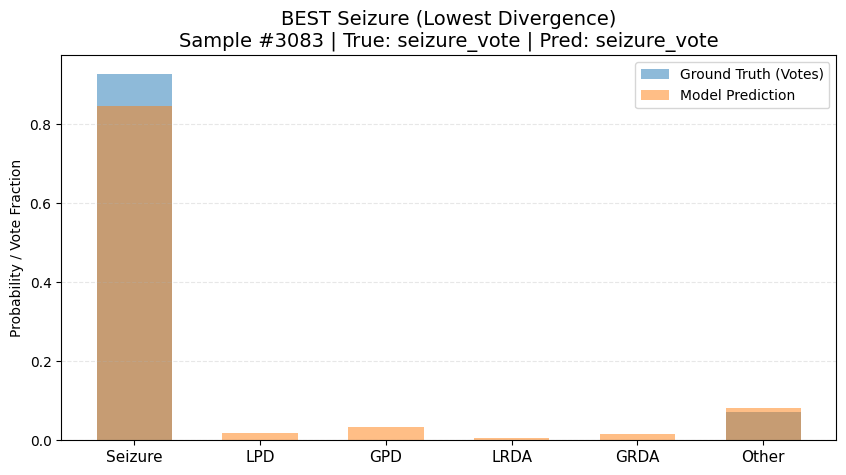

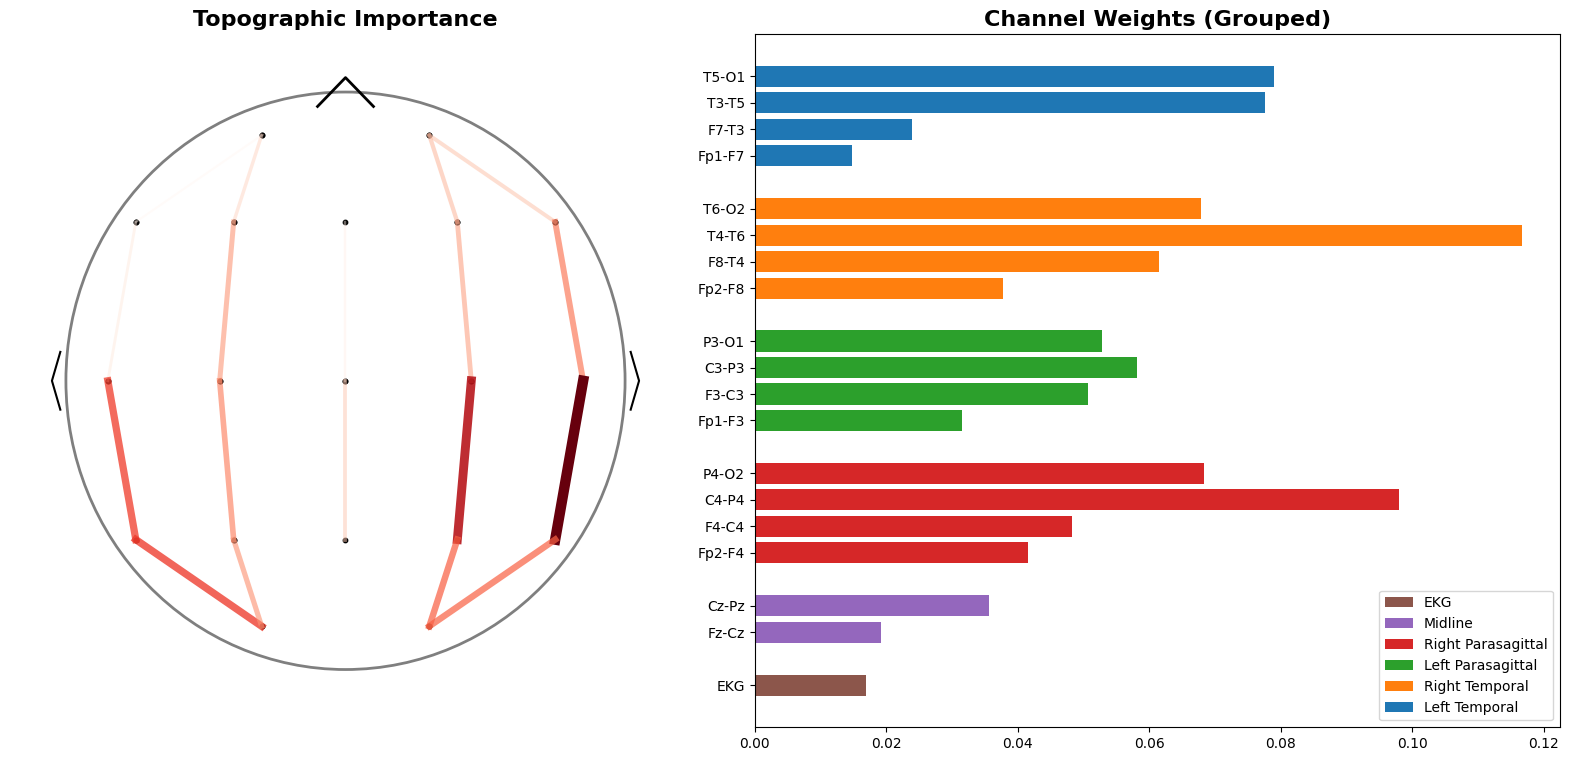

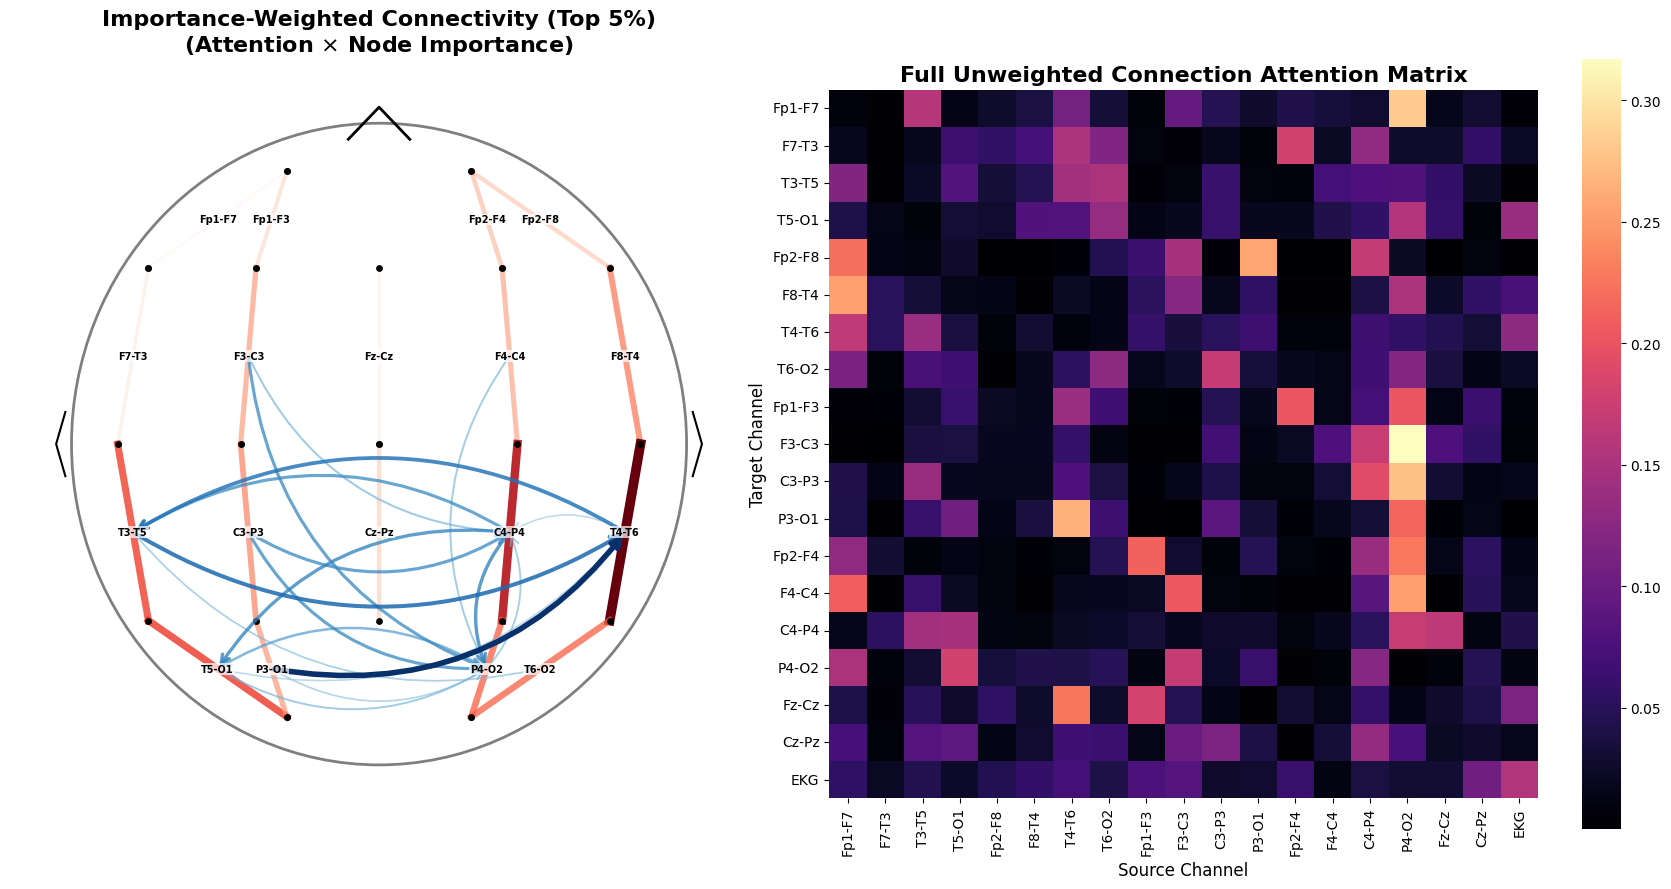

   [WORST] Index 2302 | KLD: 4.8469


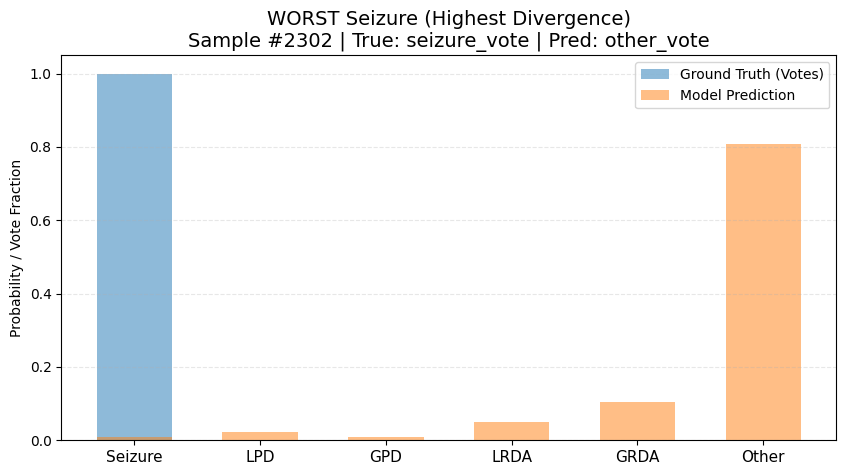

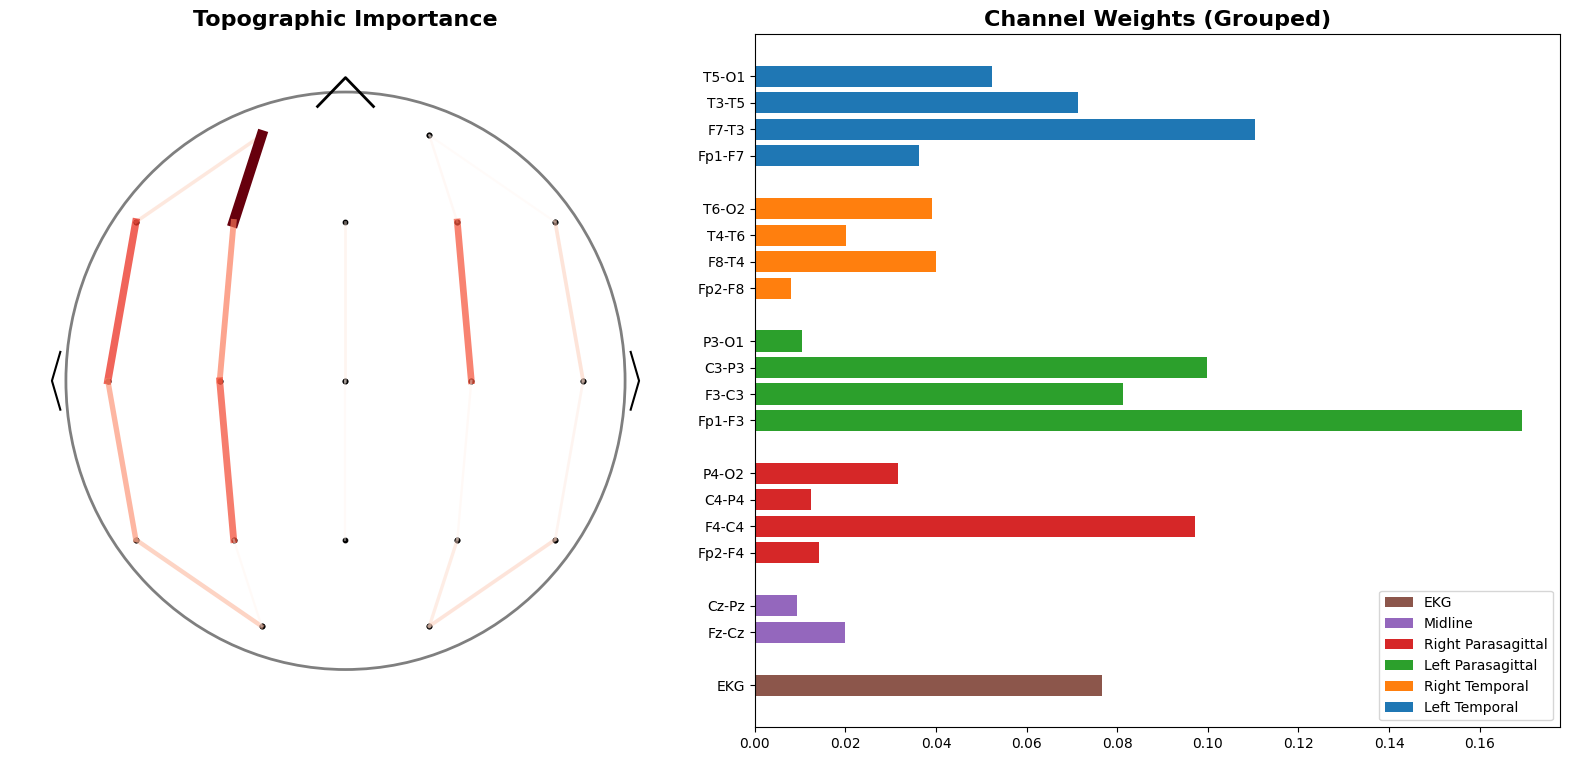

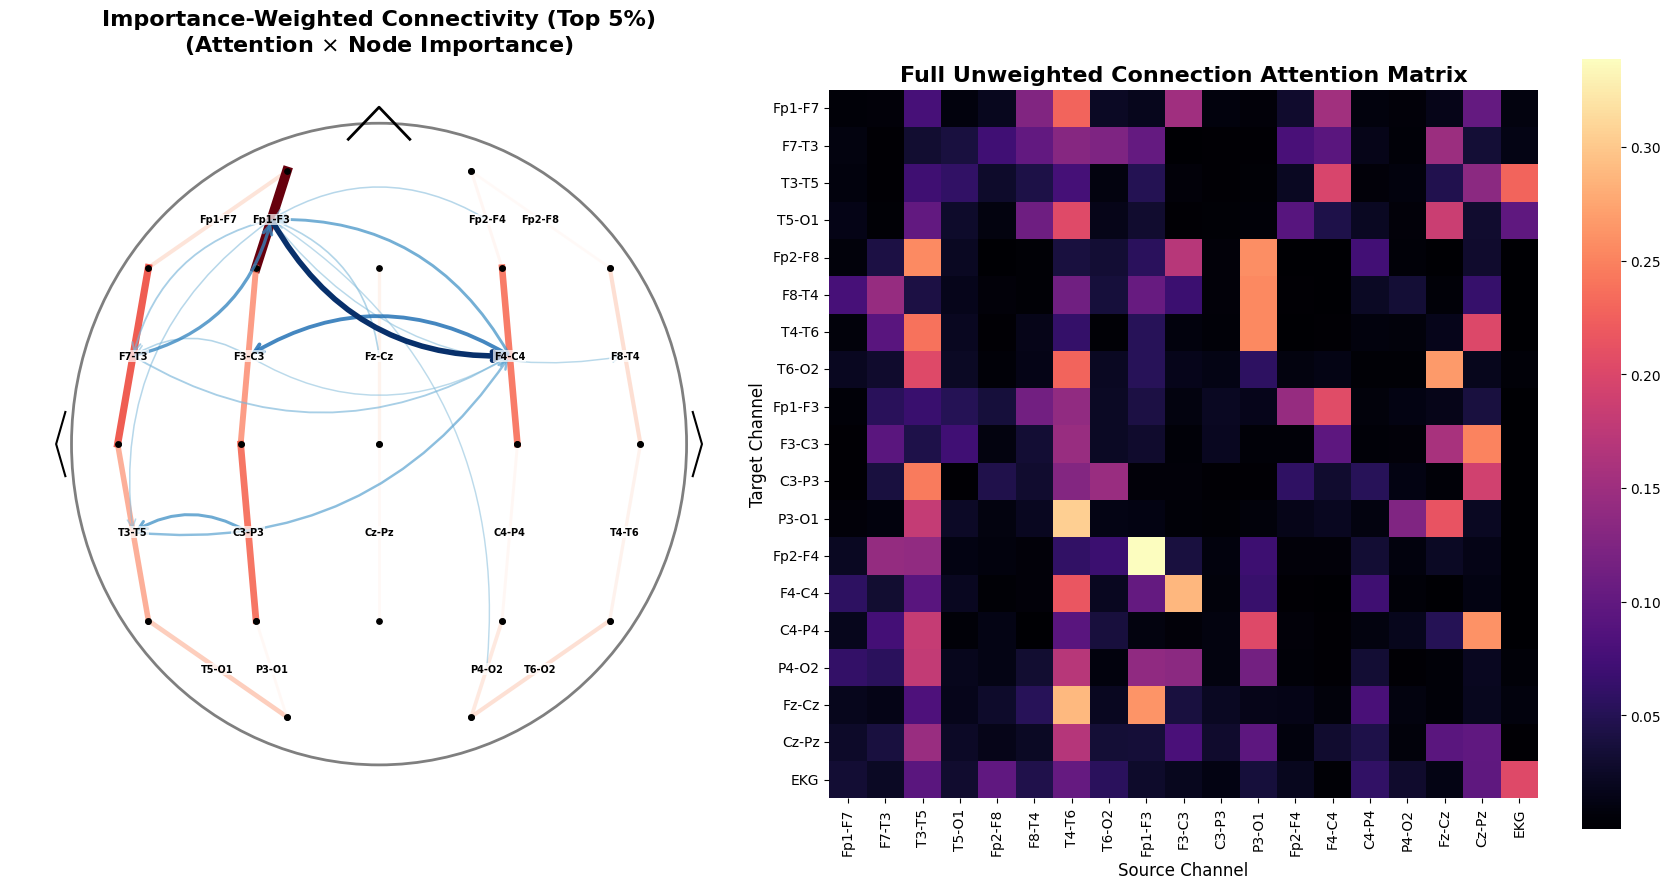


---> Analyzing Class: LPD
   [BEST] Index 3044 | KLD: 0.0408


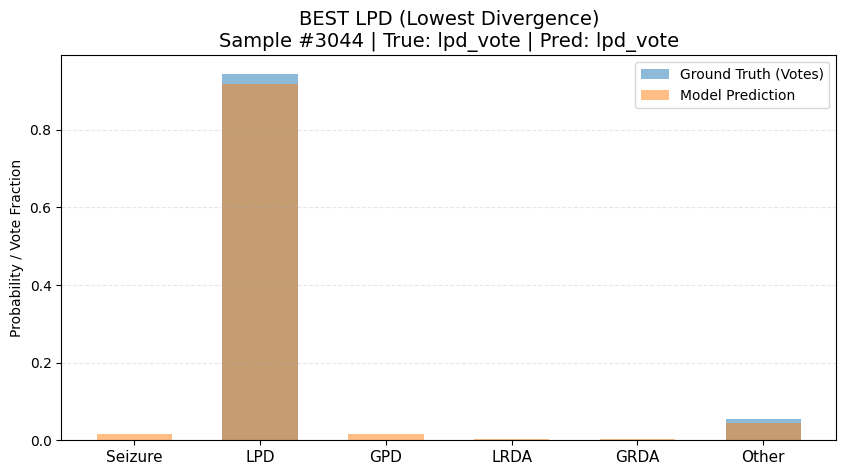

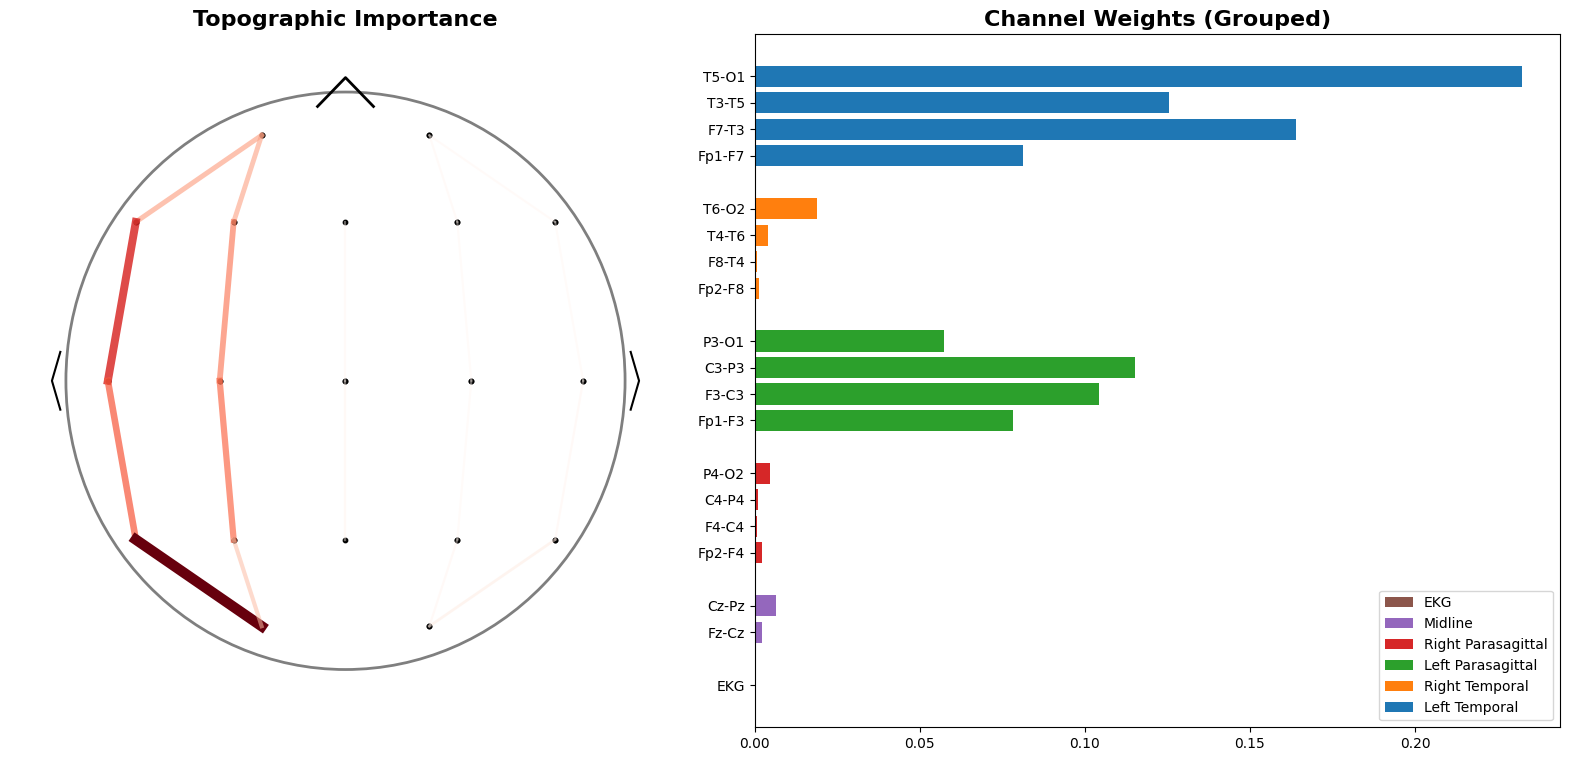

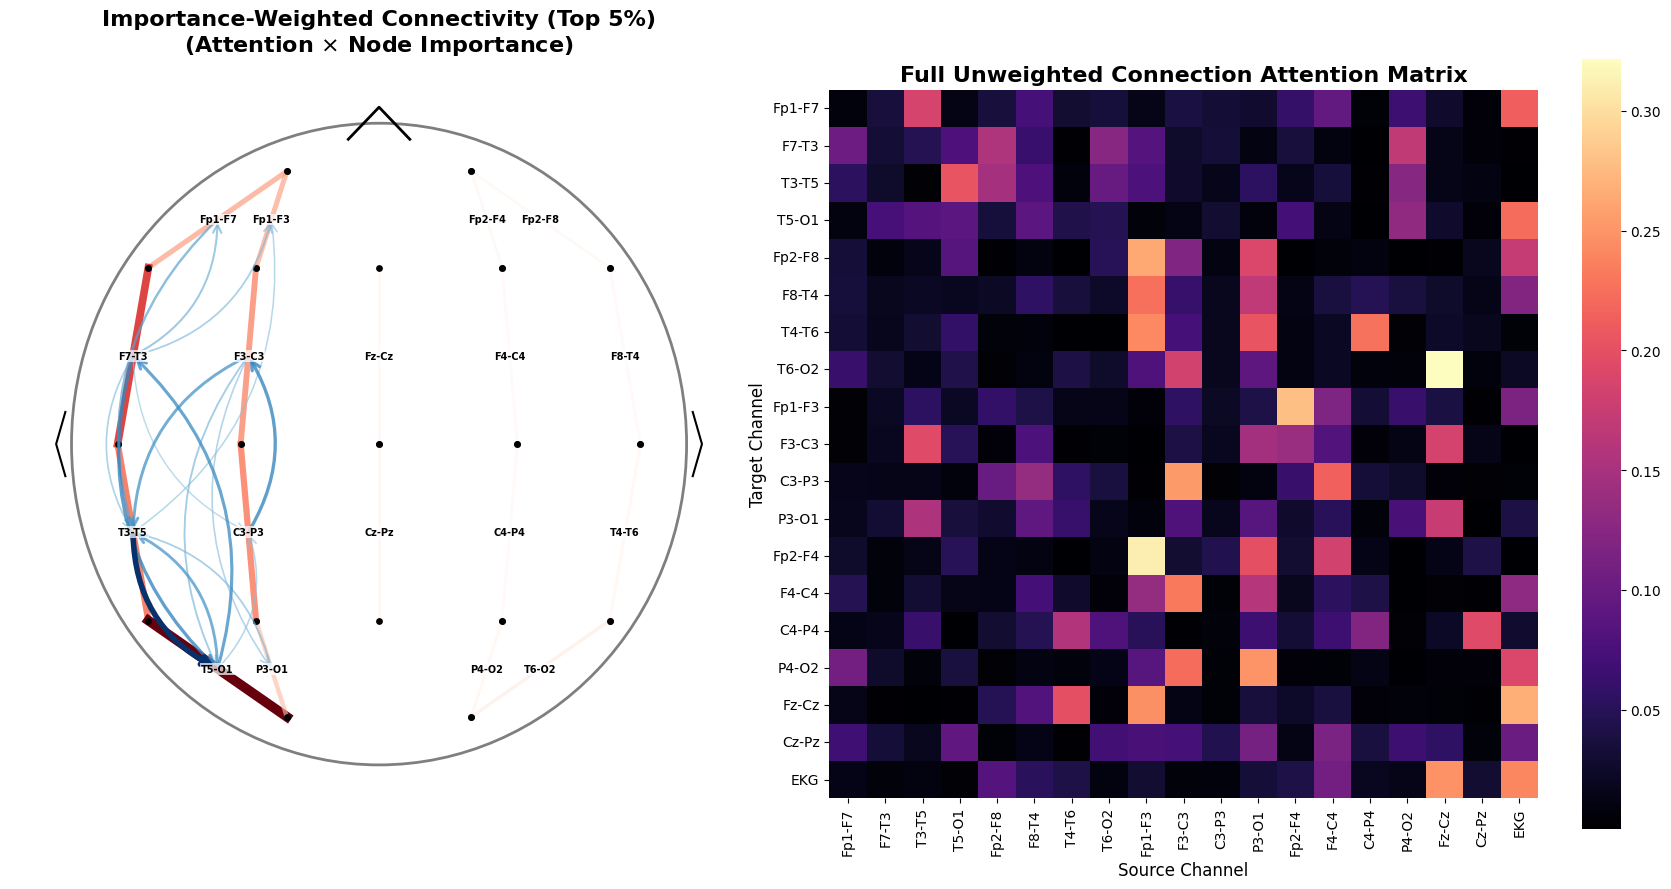

   [WORST] Index 1469 | KLD: 3.1097


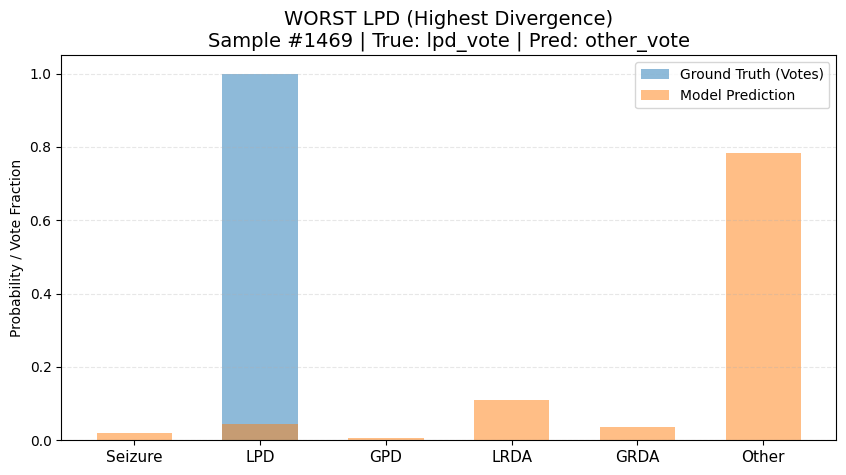

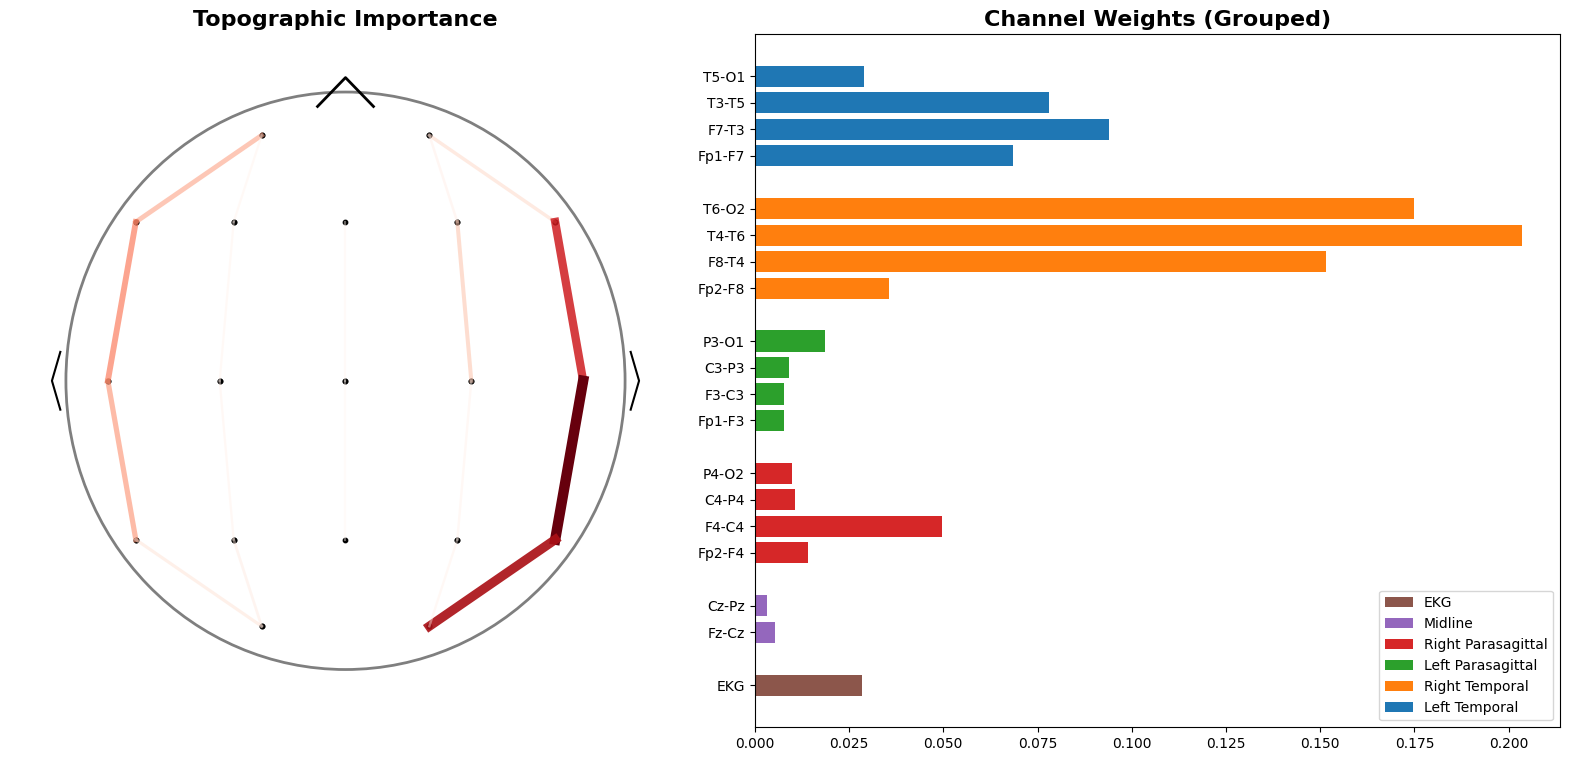

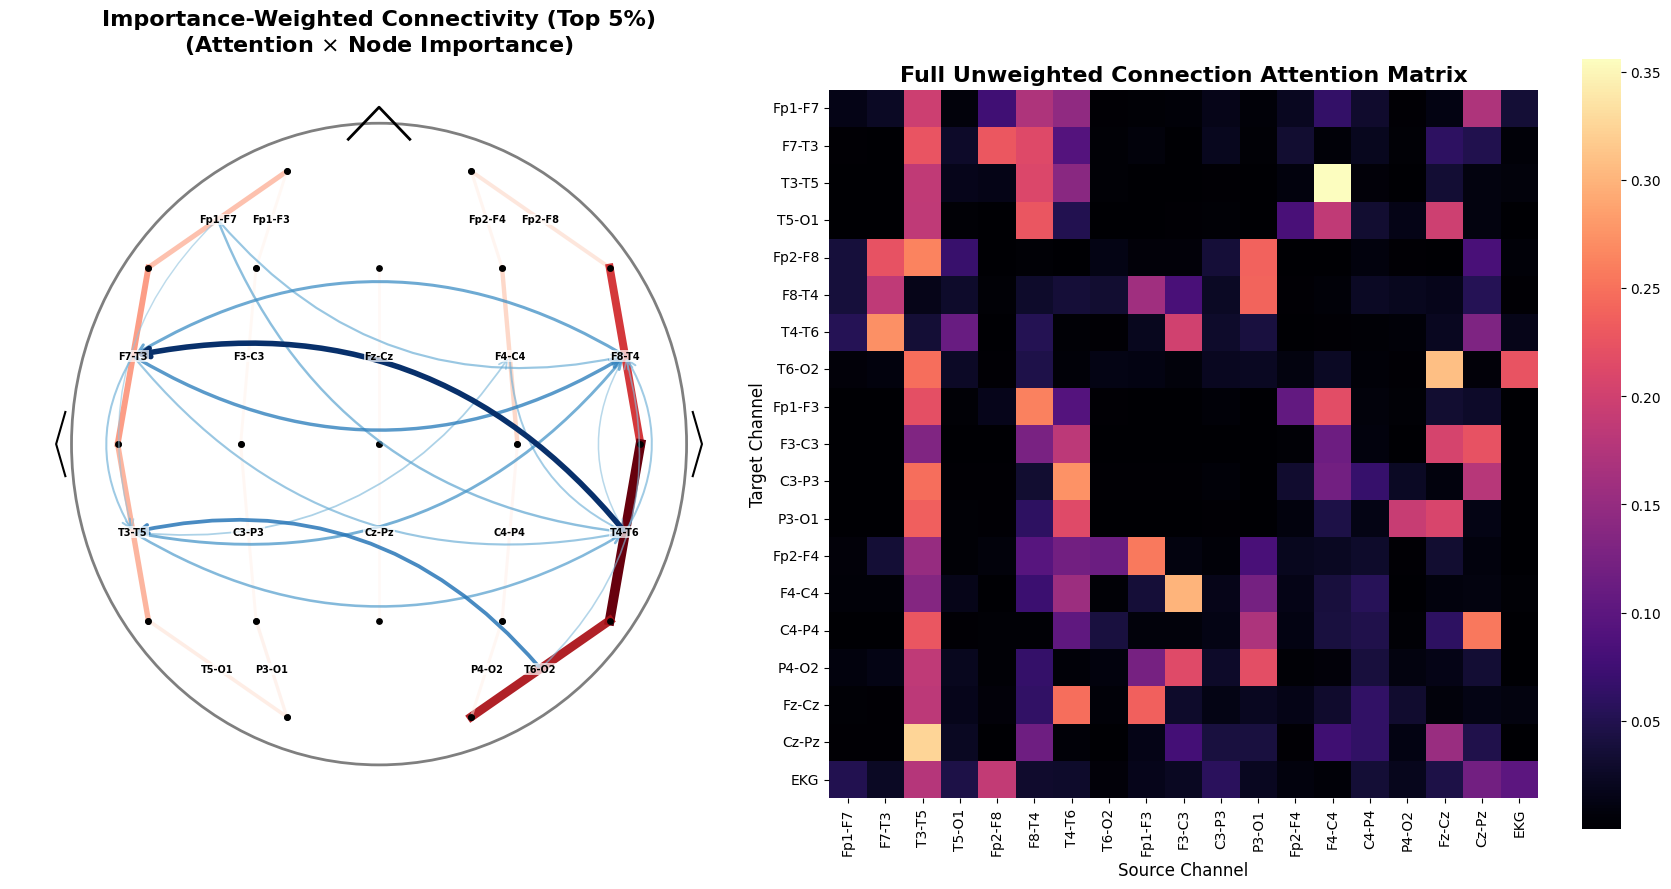


---> Analyzing Class: GPD
   [BEST] Index 2528 | KLD: 0.0829


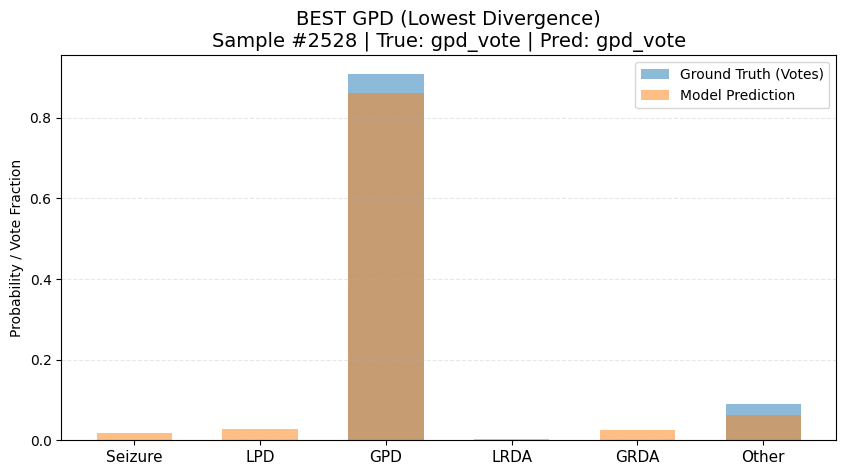

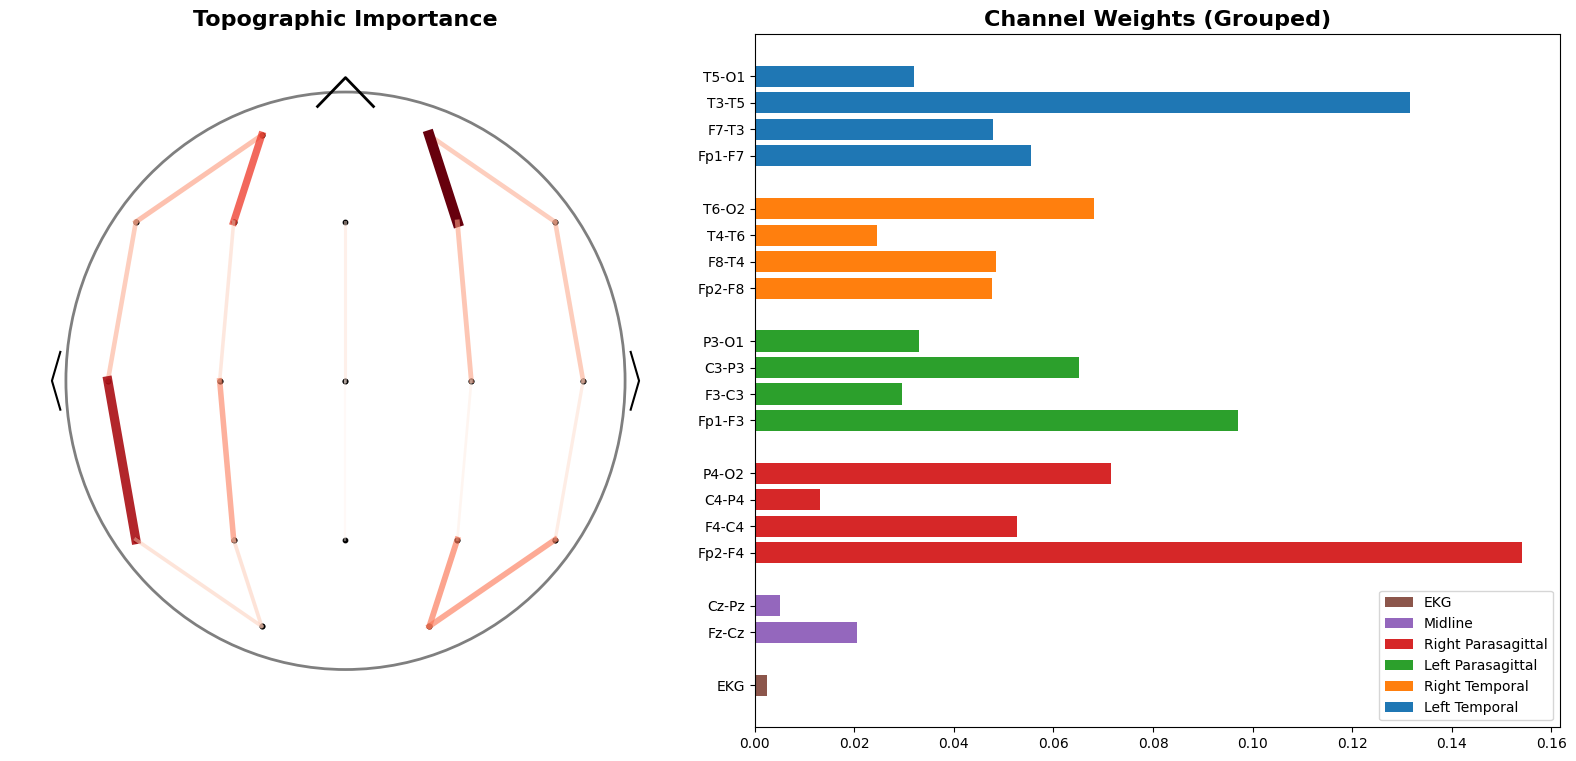

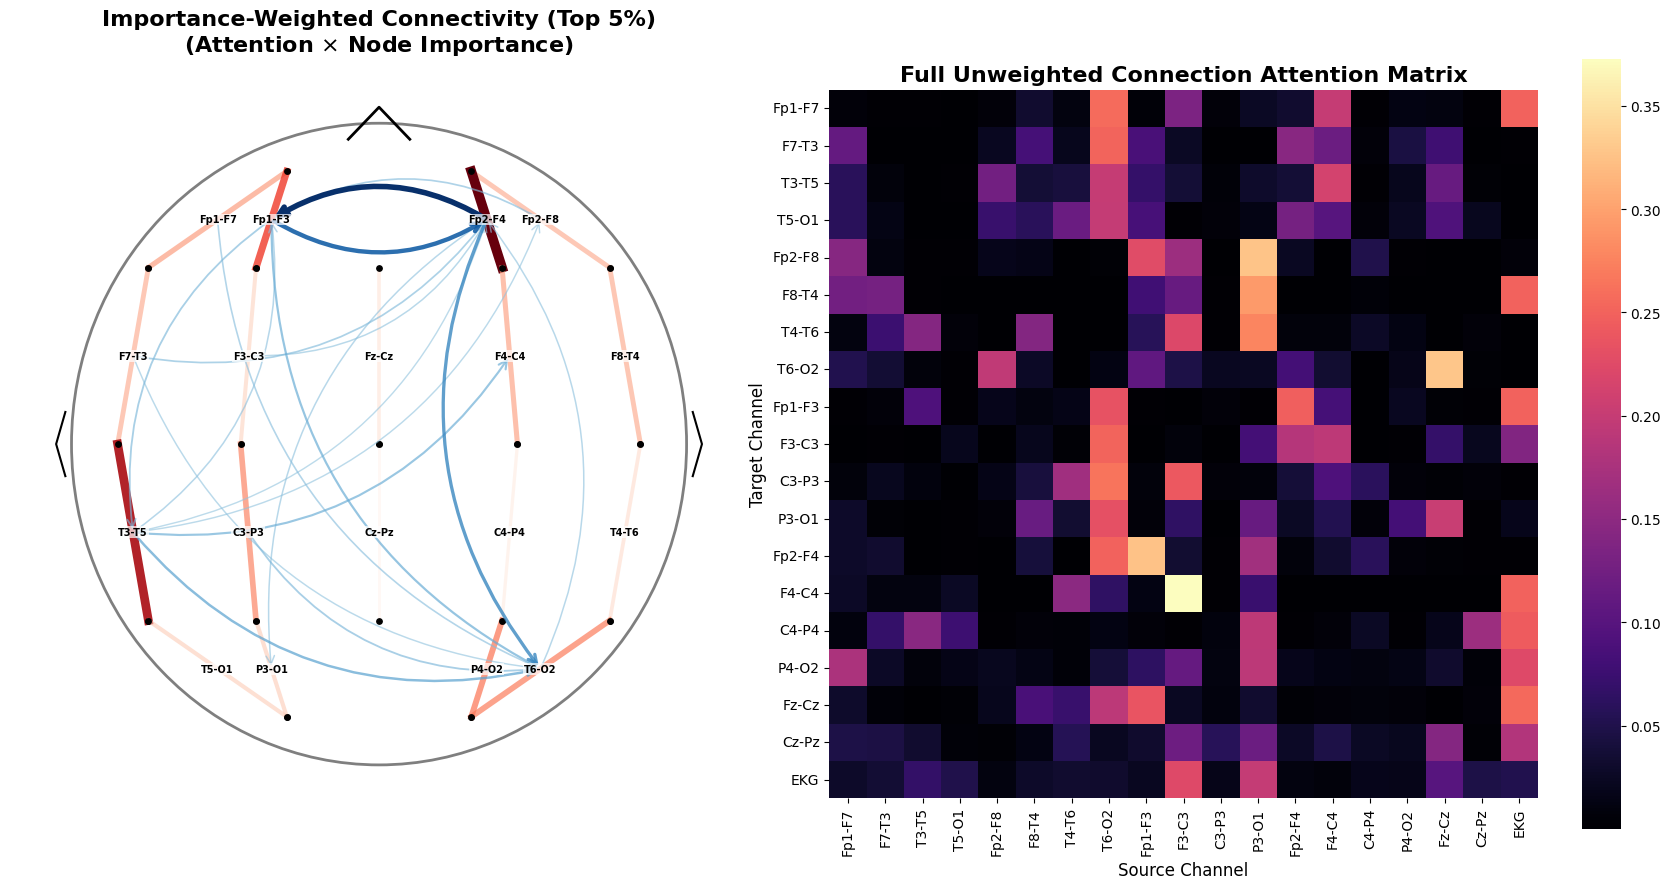

   [WORST] Index 1435 | KLD: 2.2925


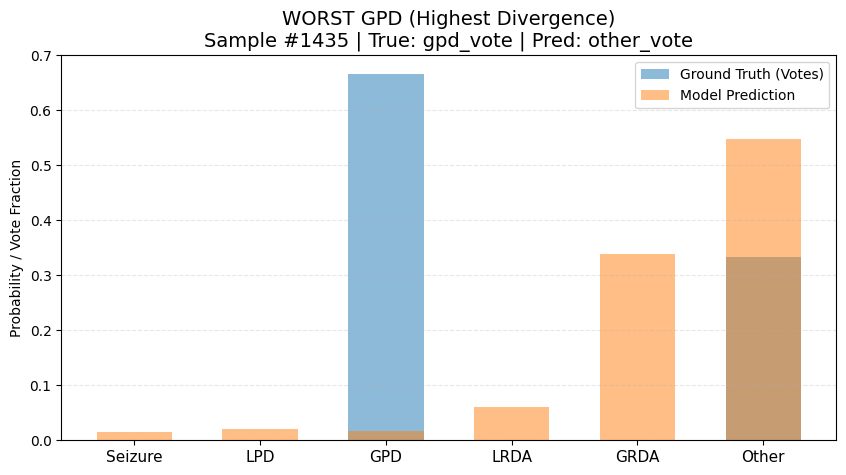

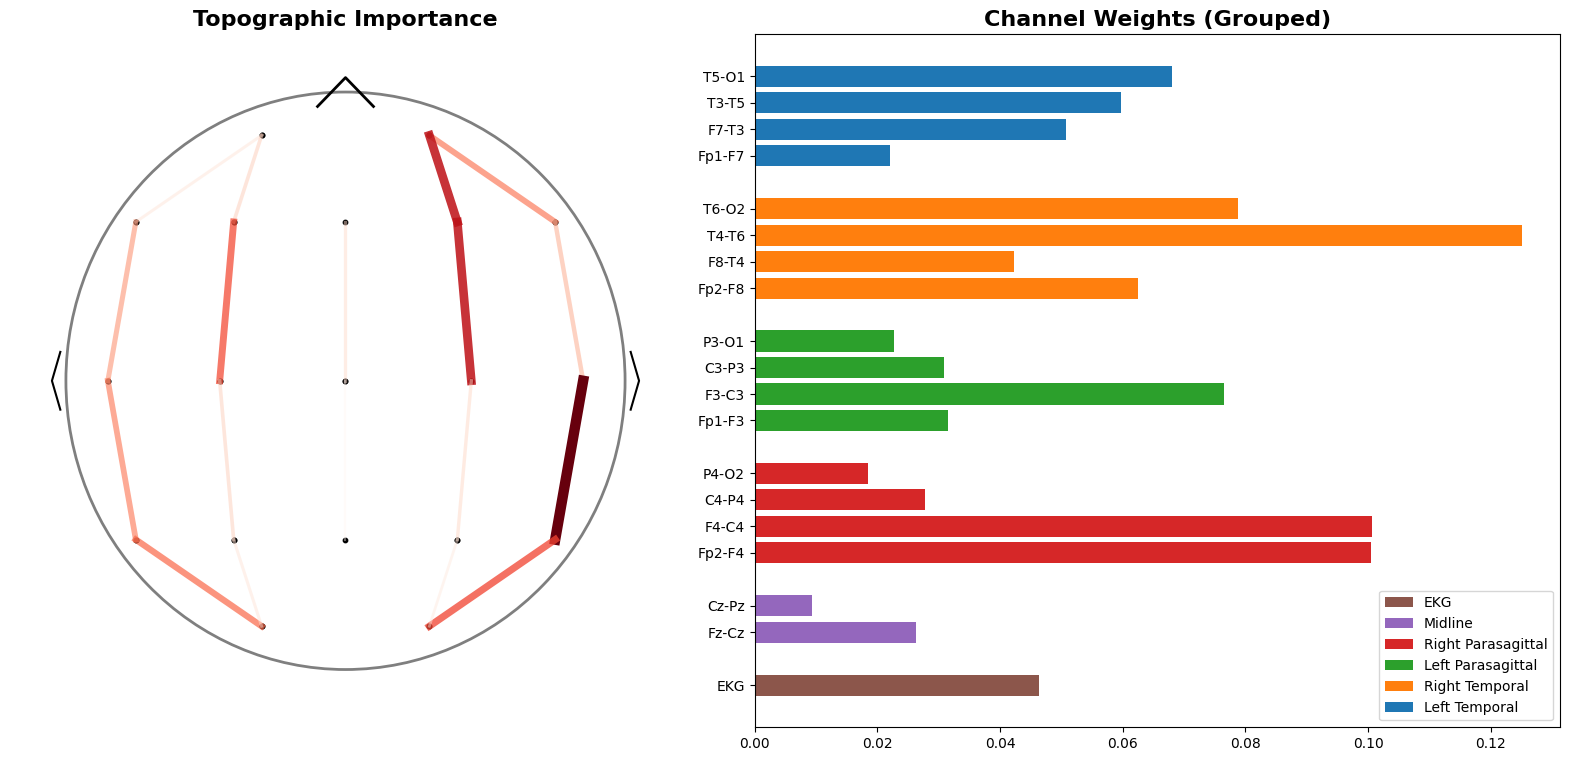

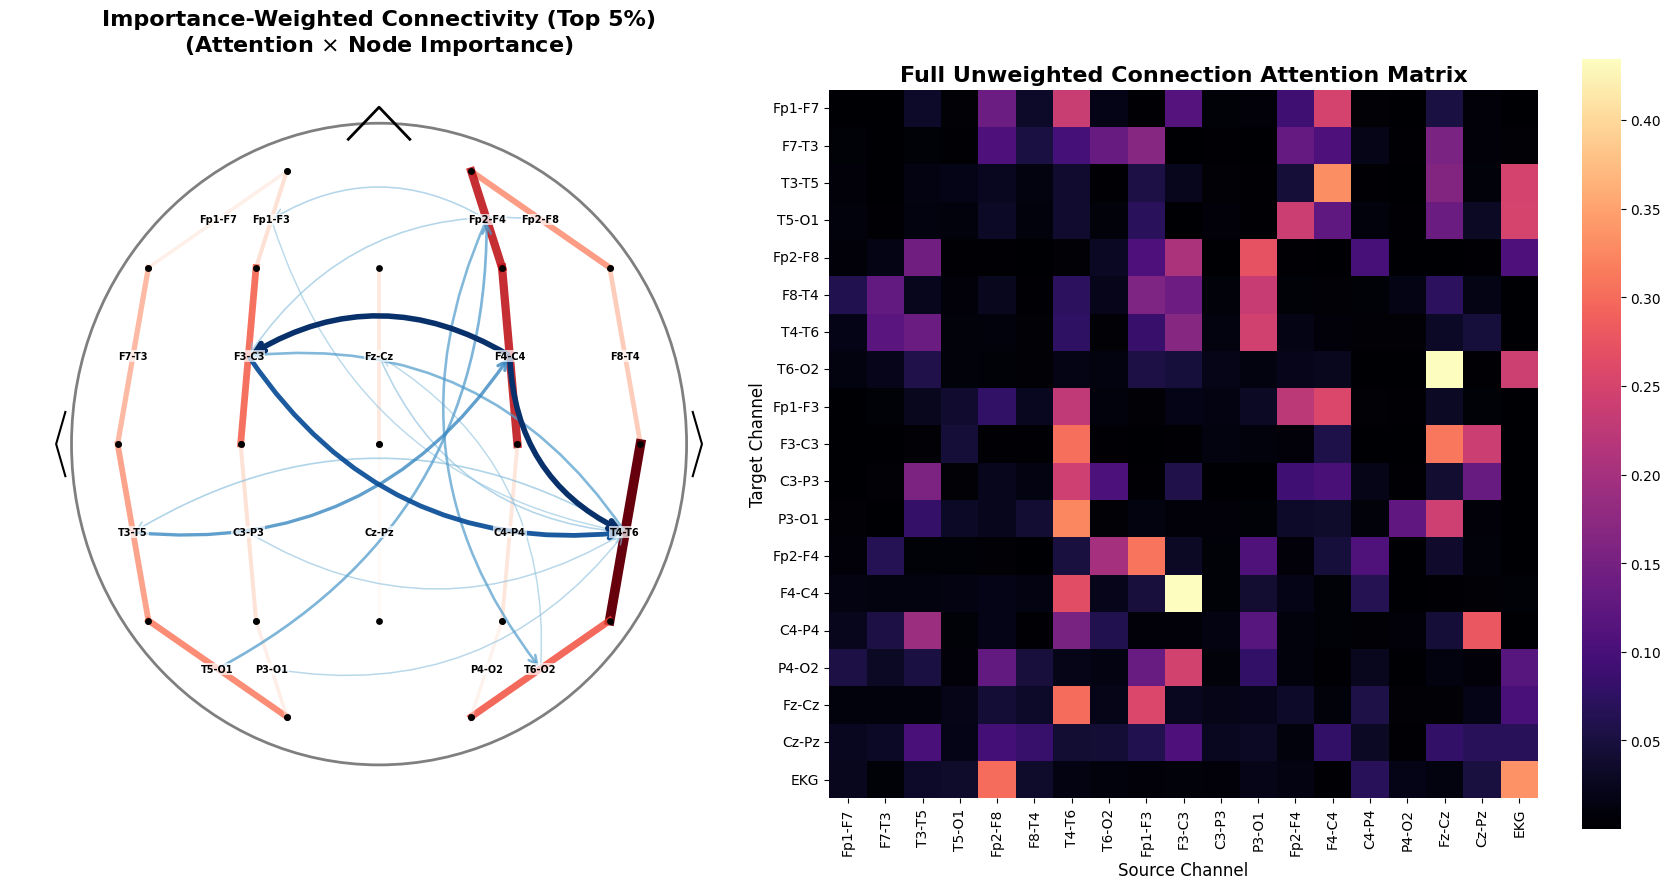


---> Analyzing Class: LRDA
   [BEST] Index 363 | KLD: 0.0828


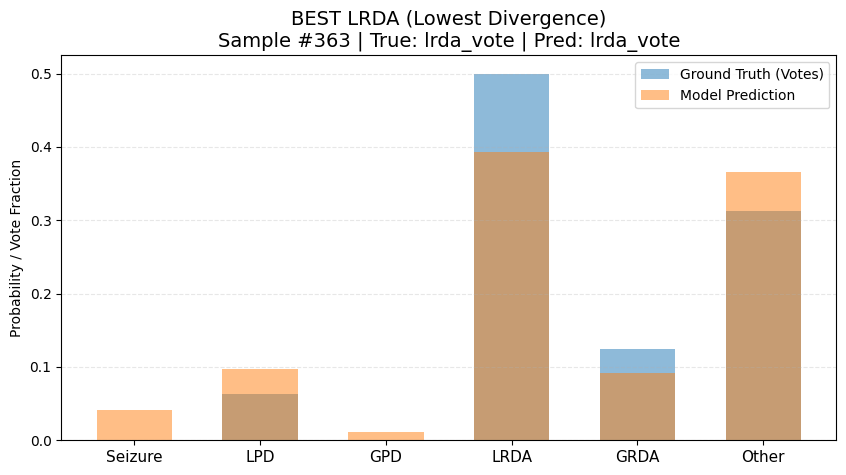

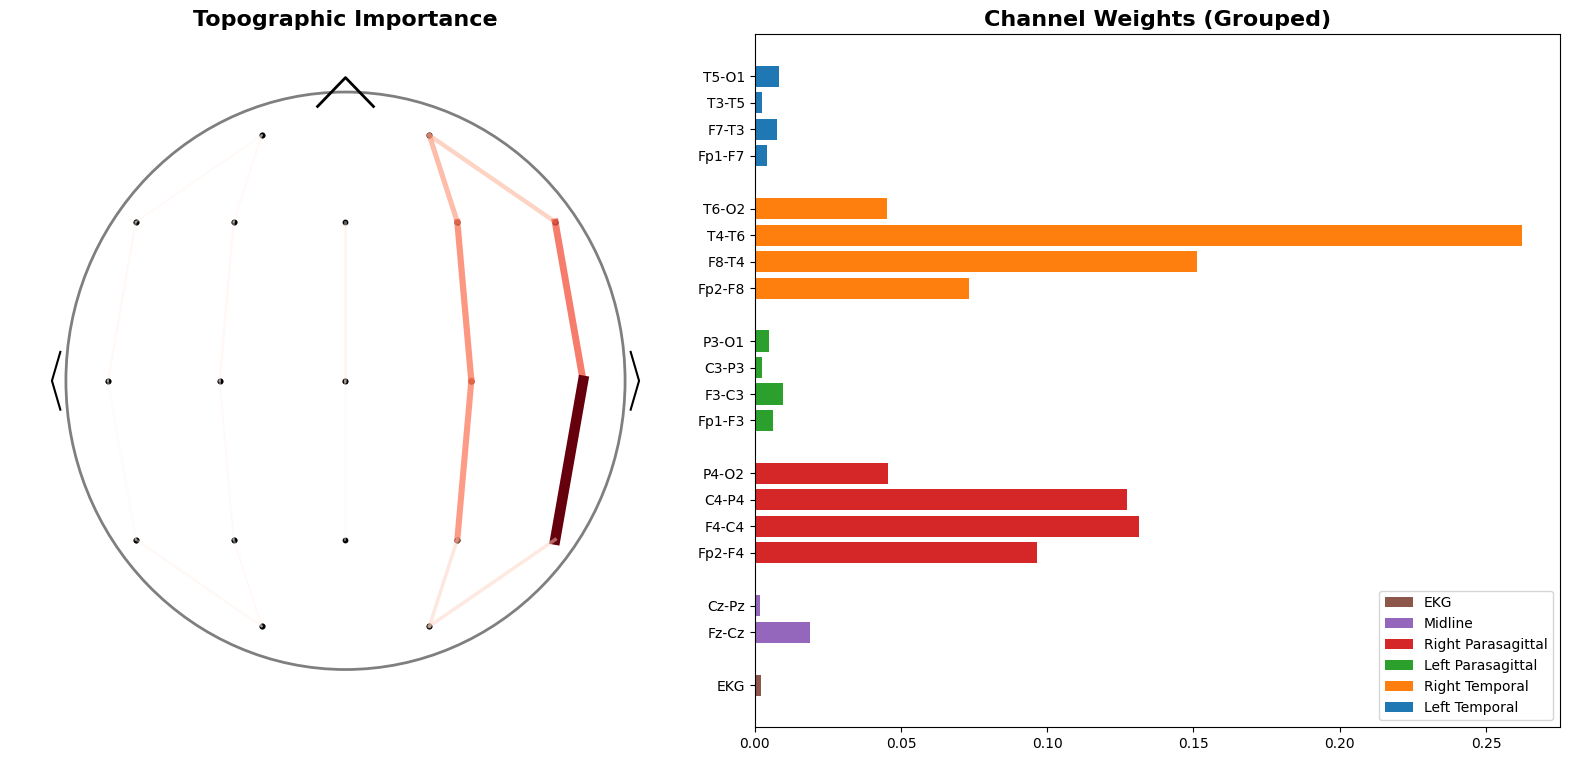

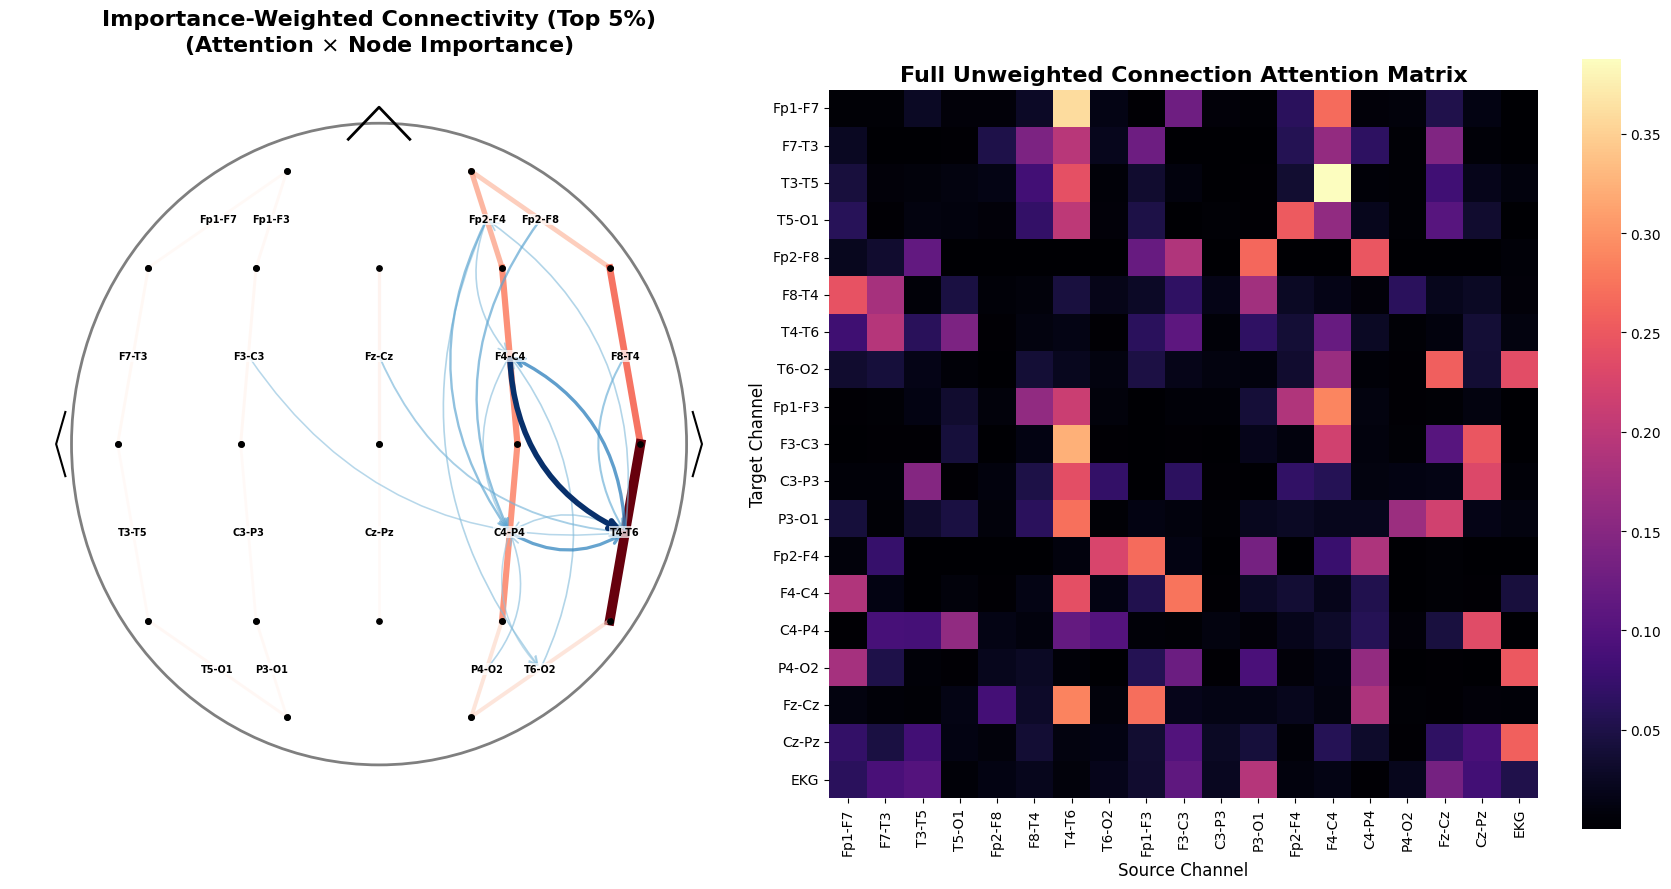

   [WORST] Index 2569 | KLD: 3.8136


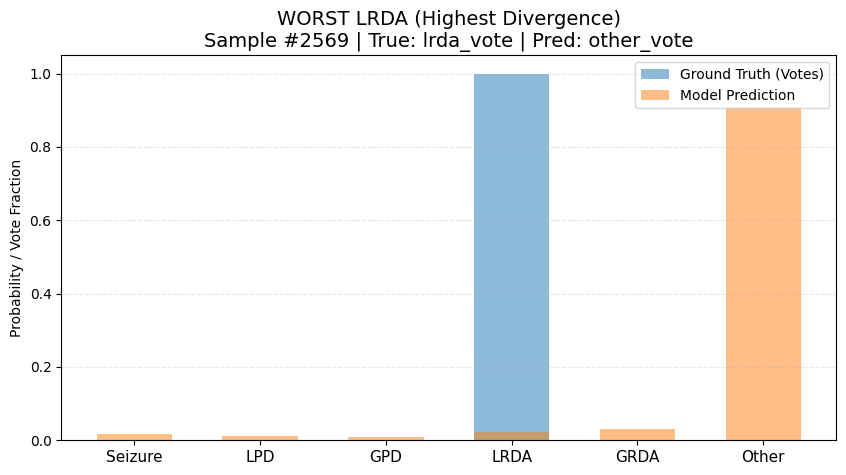

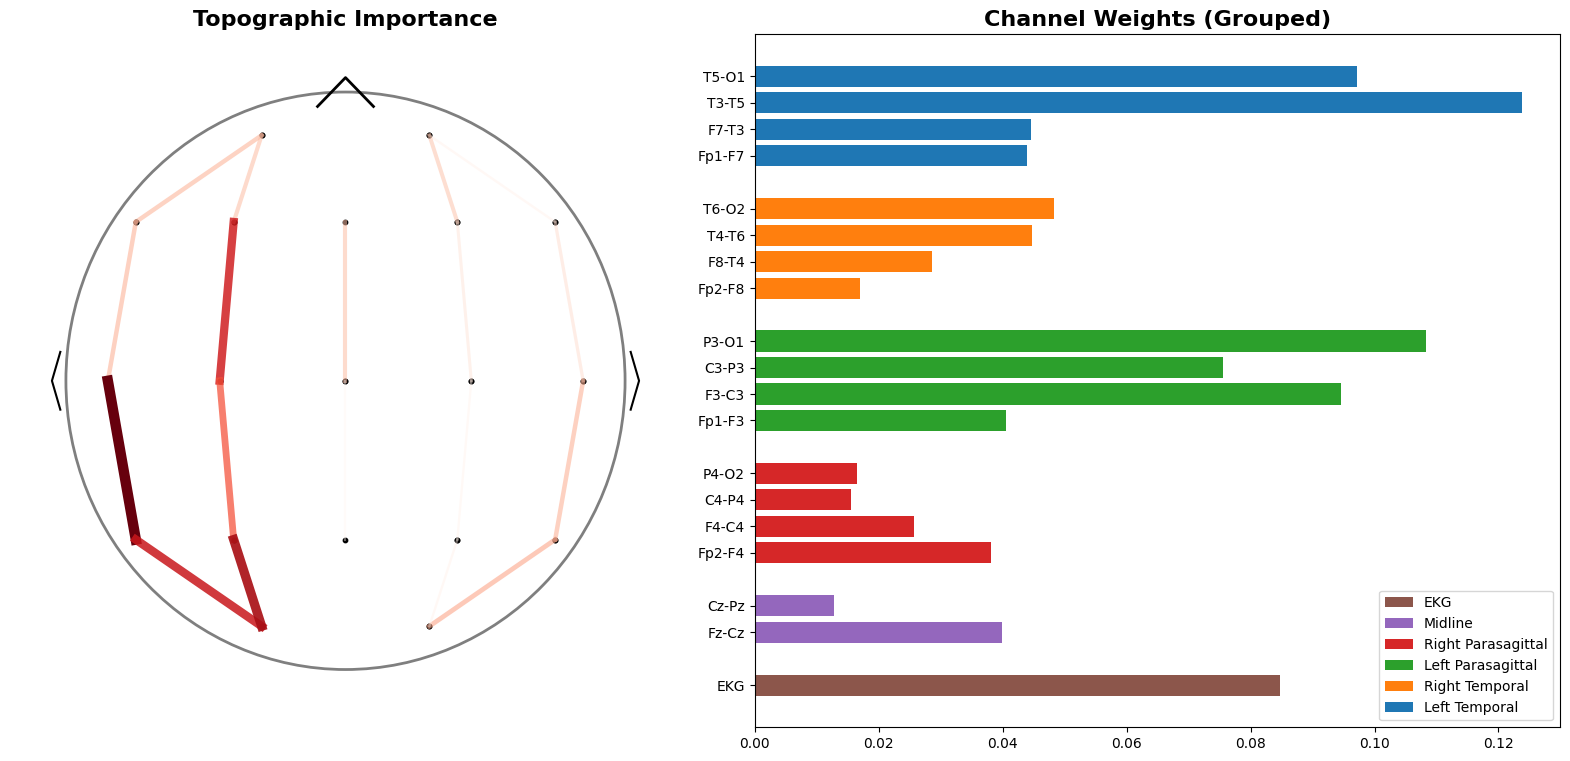

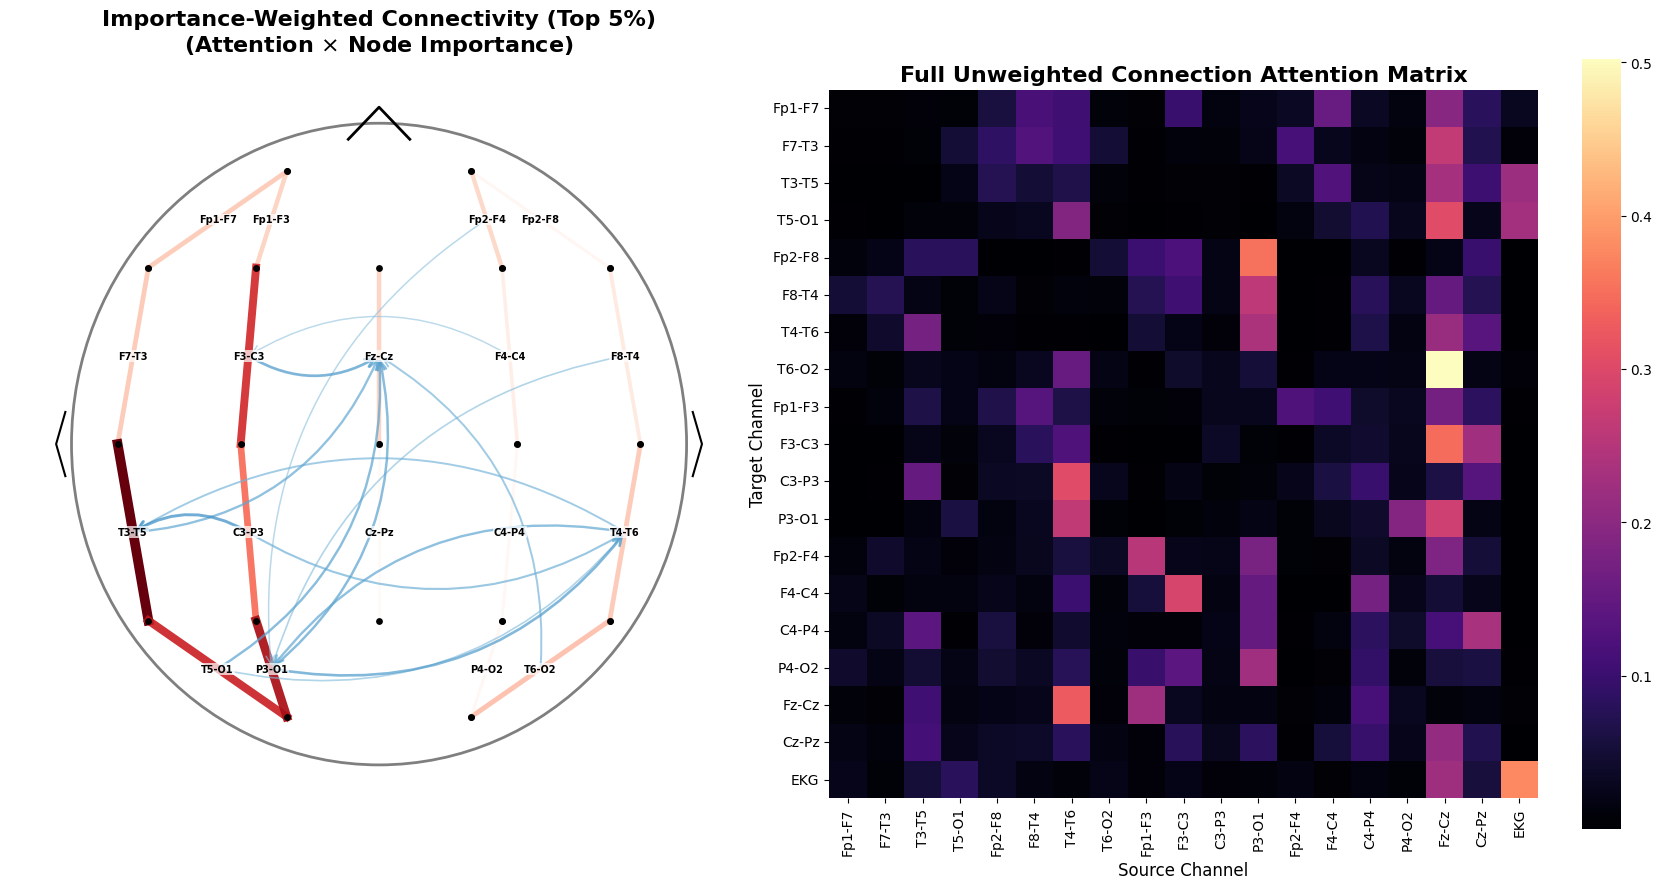


---> Analyzing Class: GRDA
   [BEST] Index 1768 | KLD: 0.0593


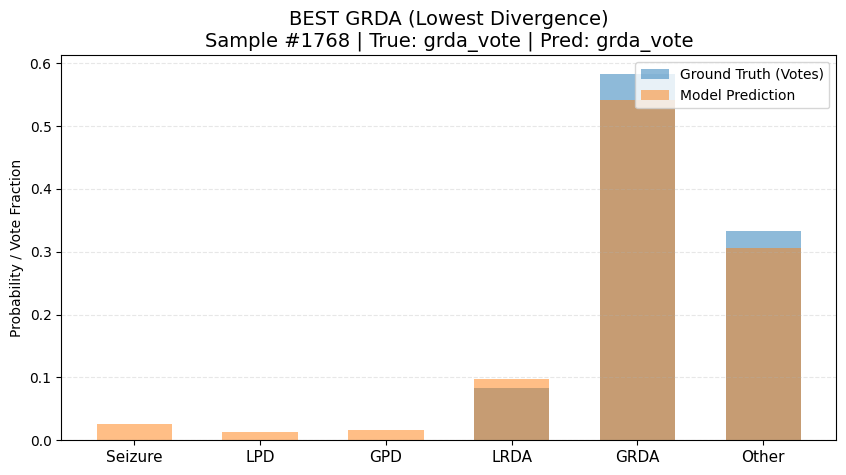

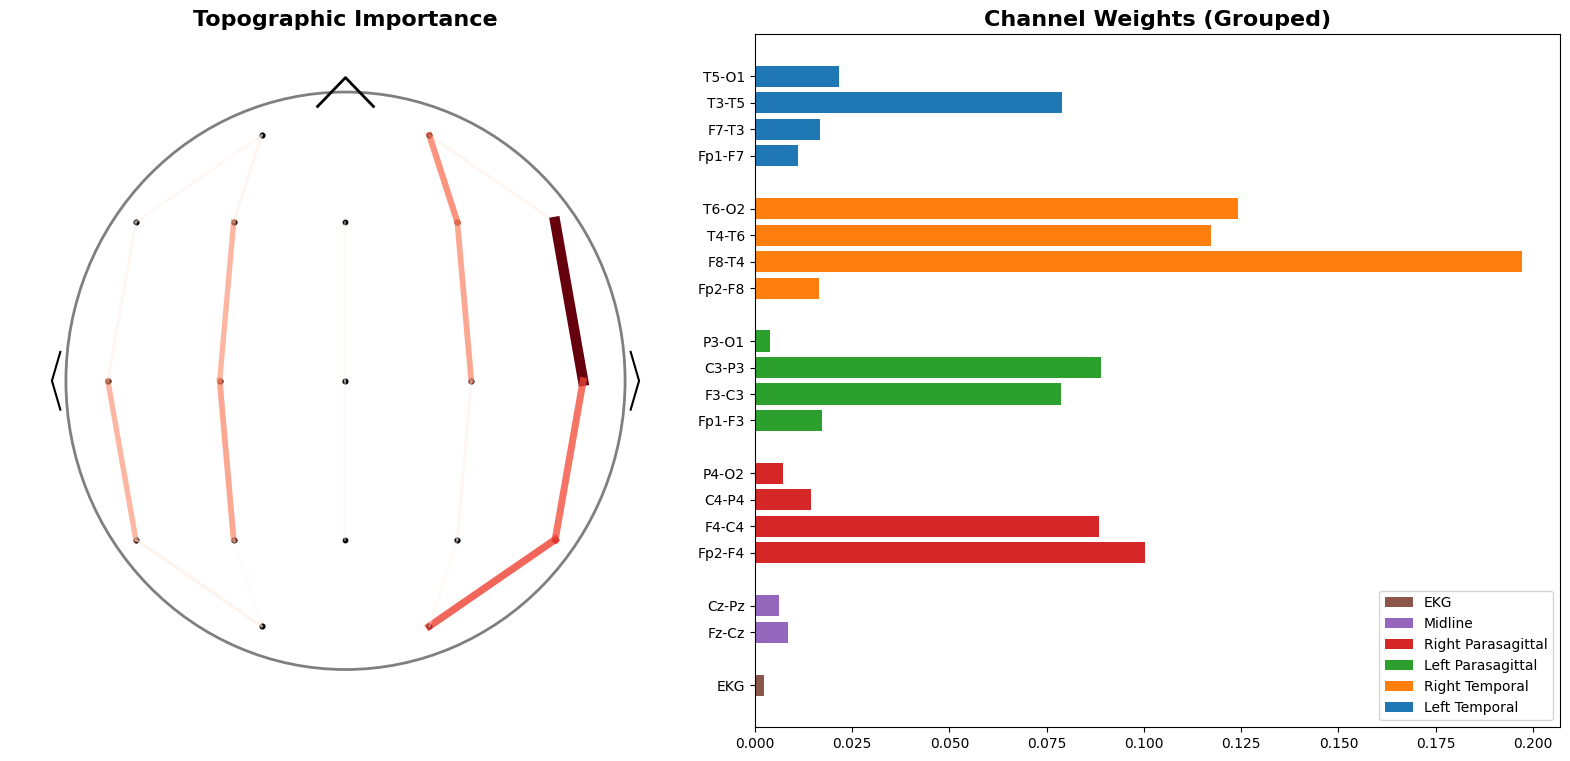

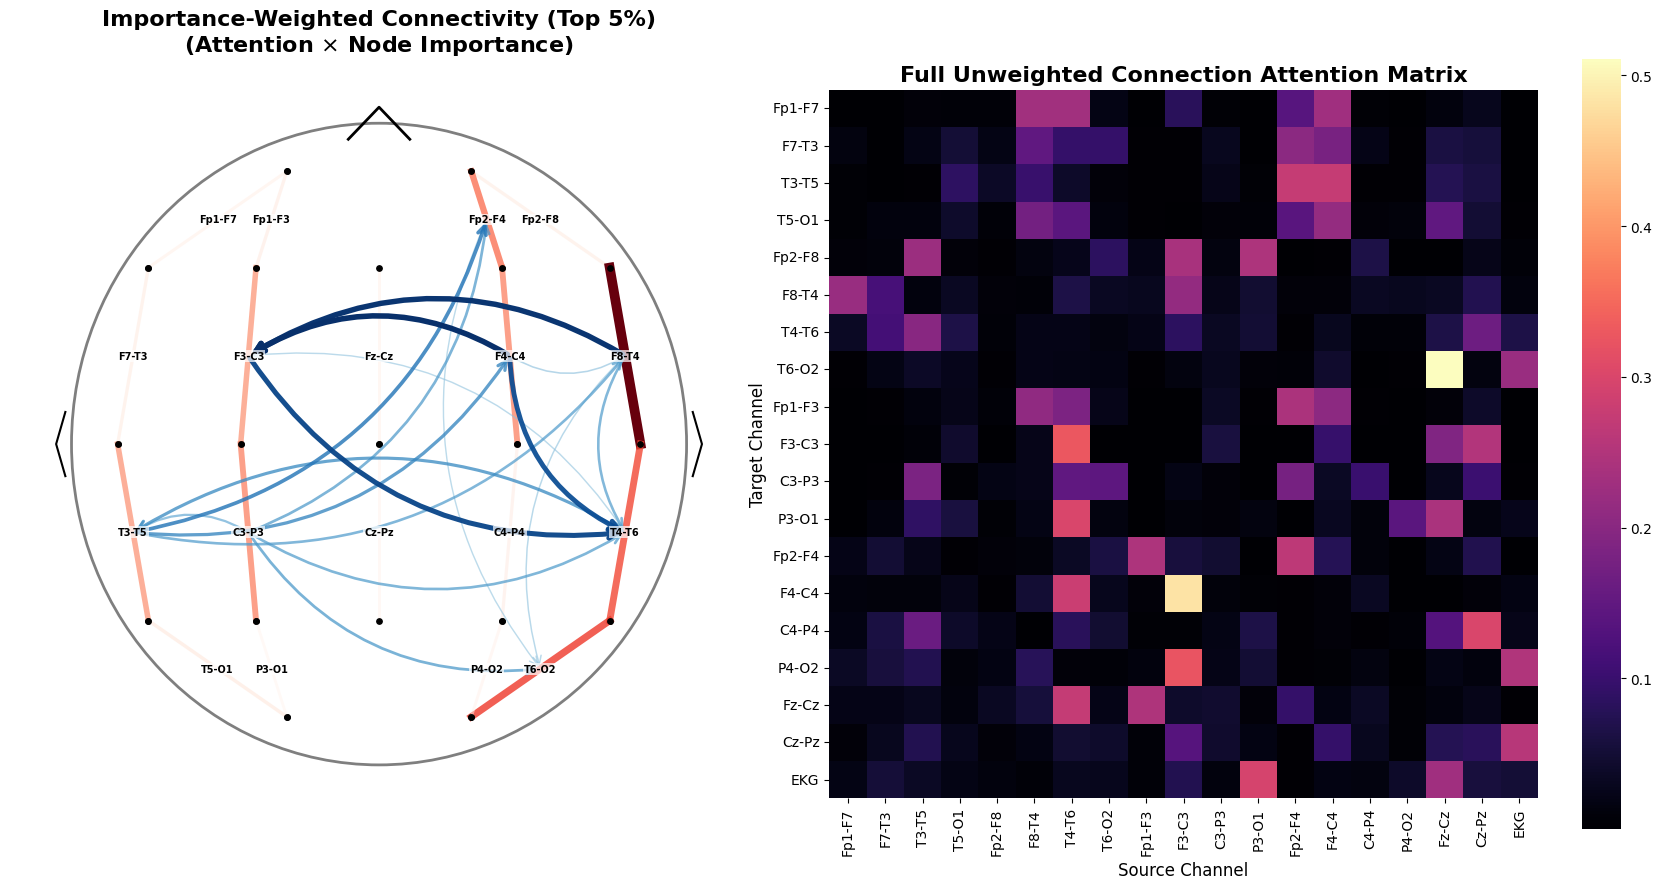

   [WORST] Index 709 | KLD: 3.3256


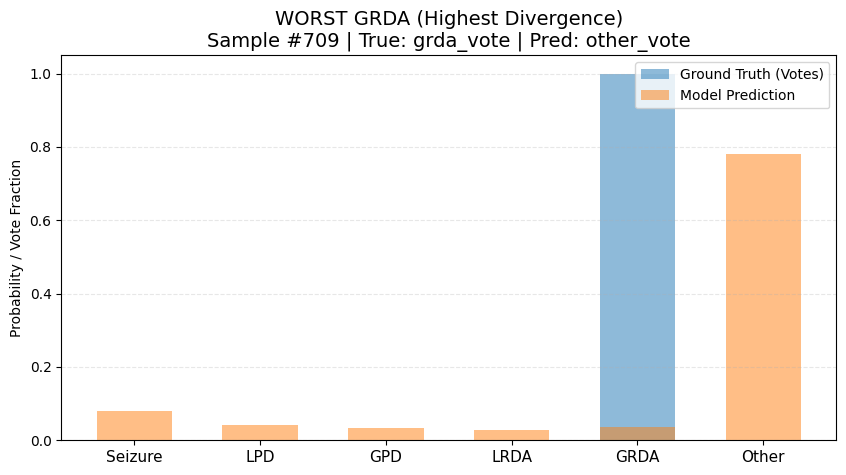

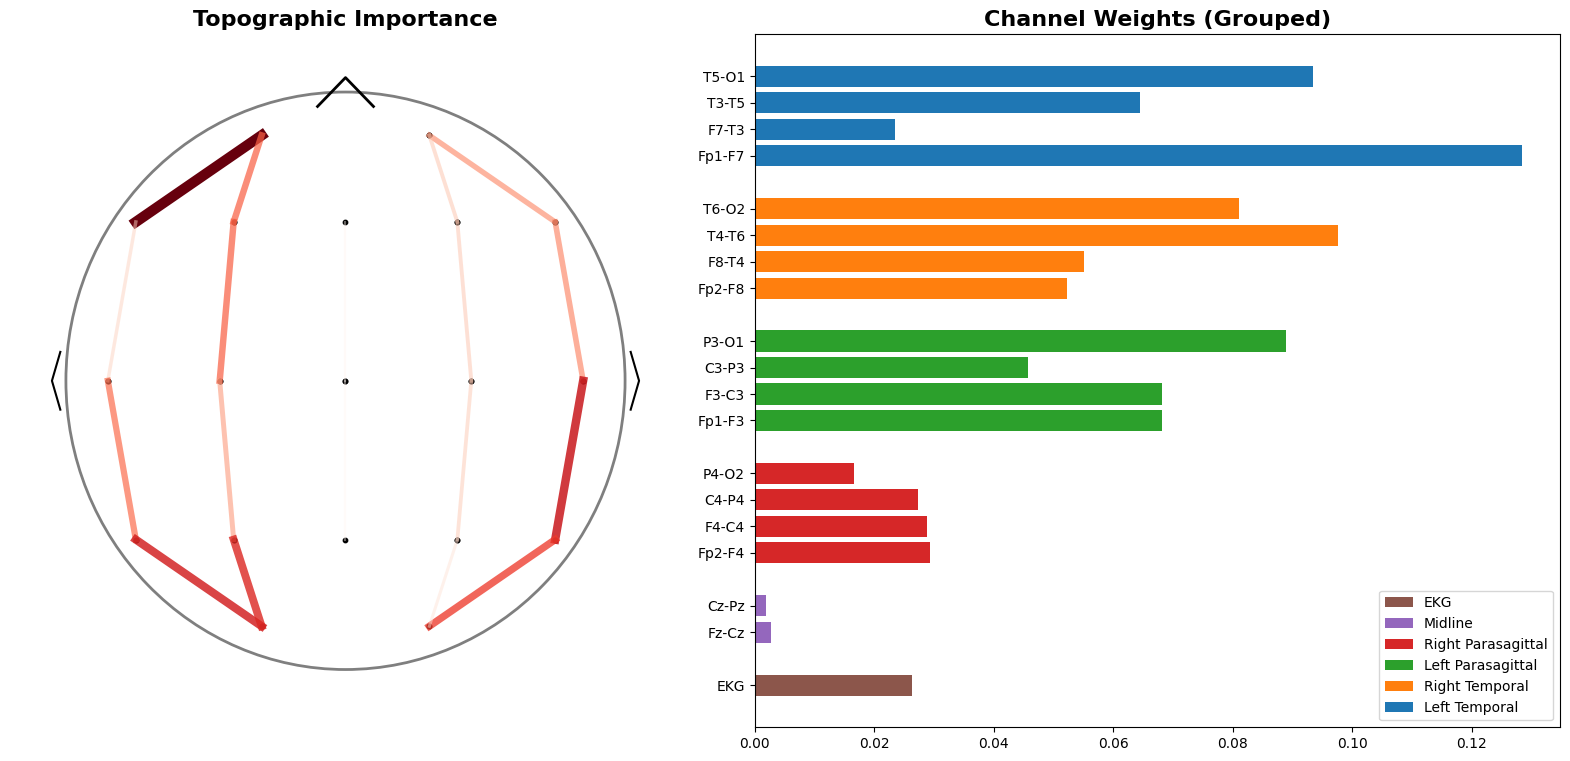

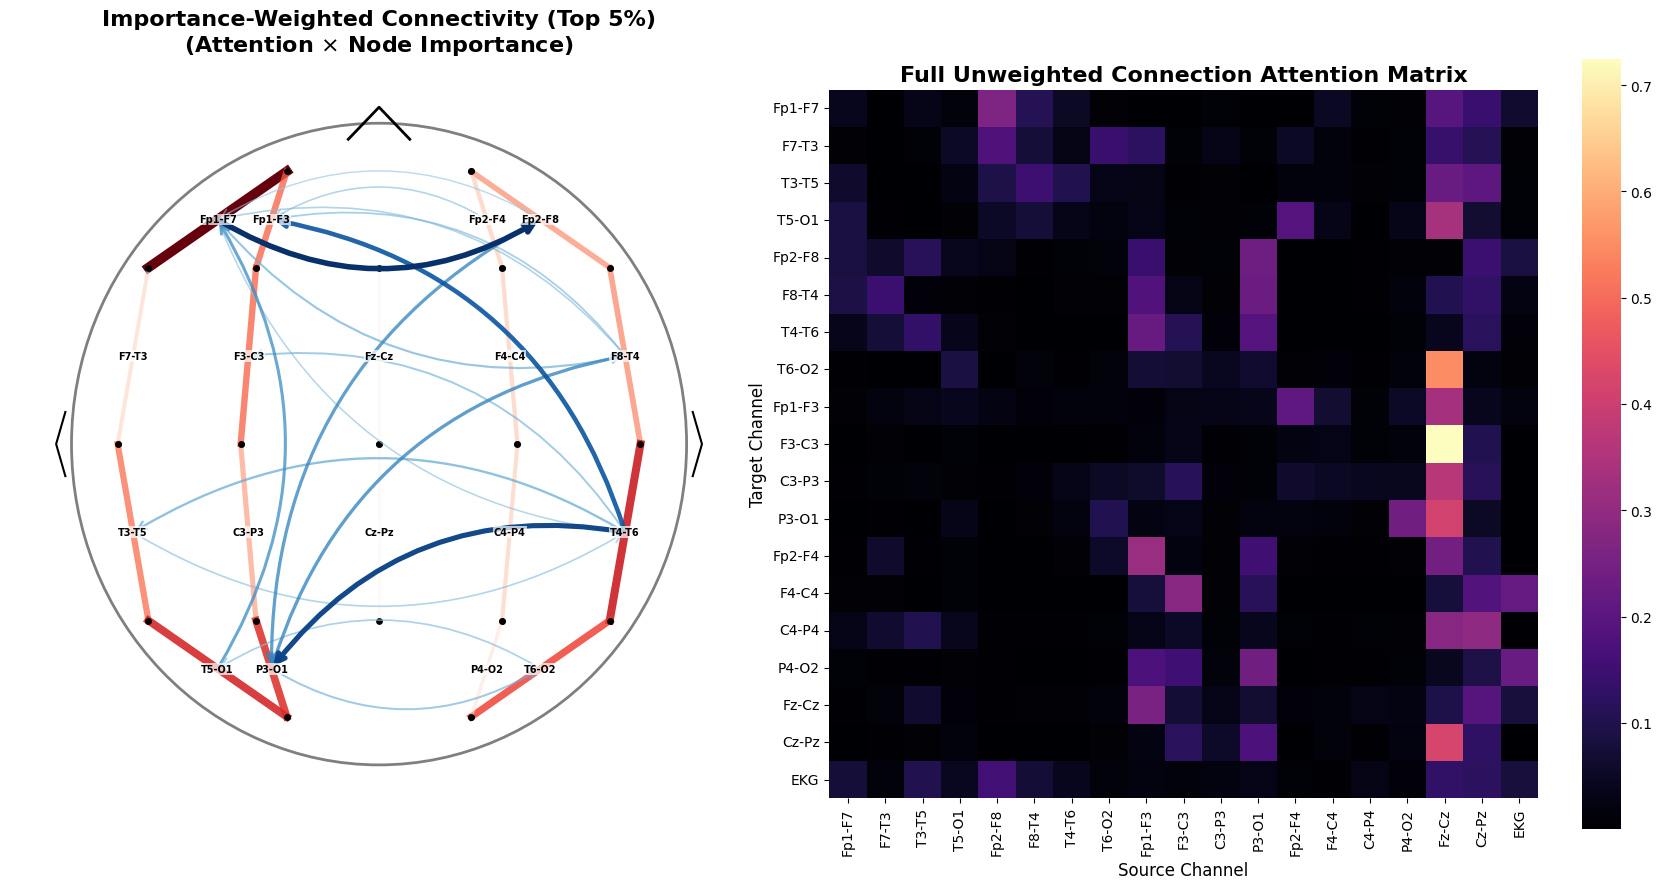


---> Analyzing Class: Other
   [BEST] Index 154 | KLD: 0.0364


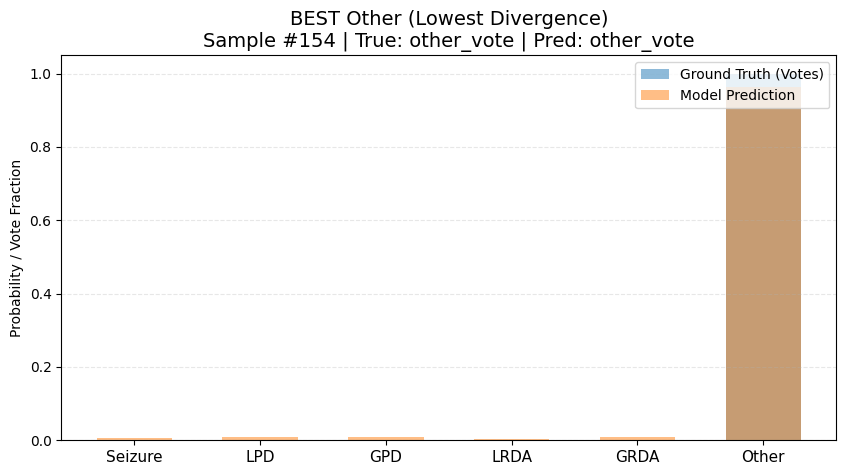

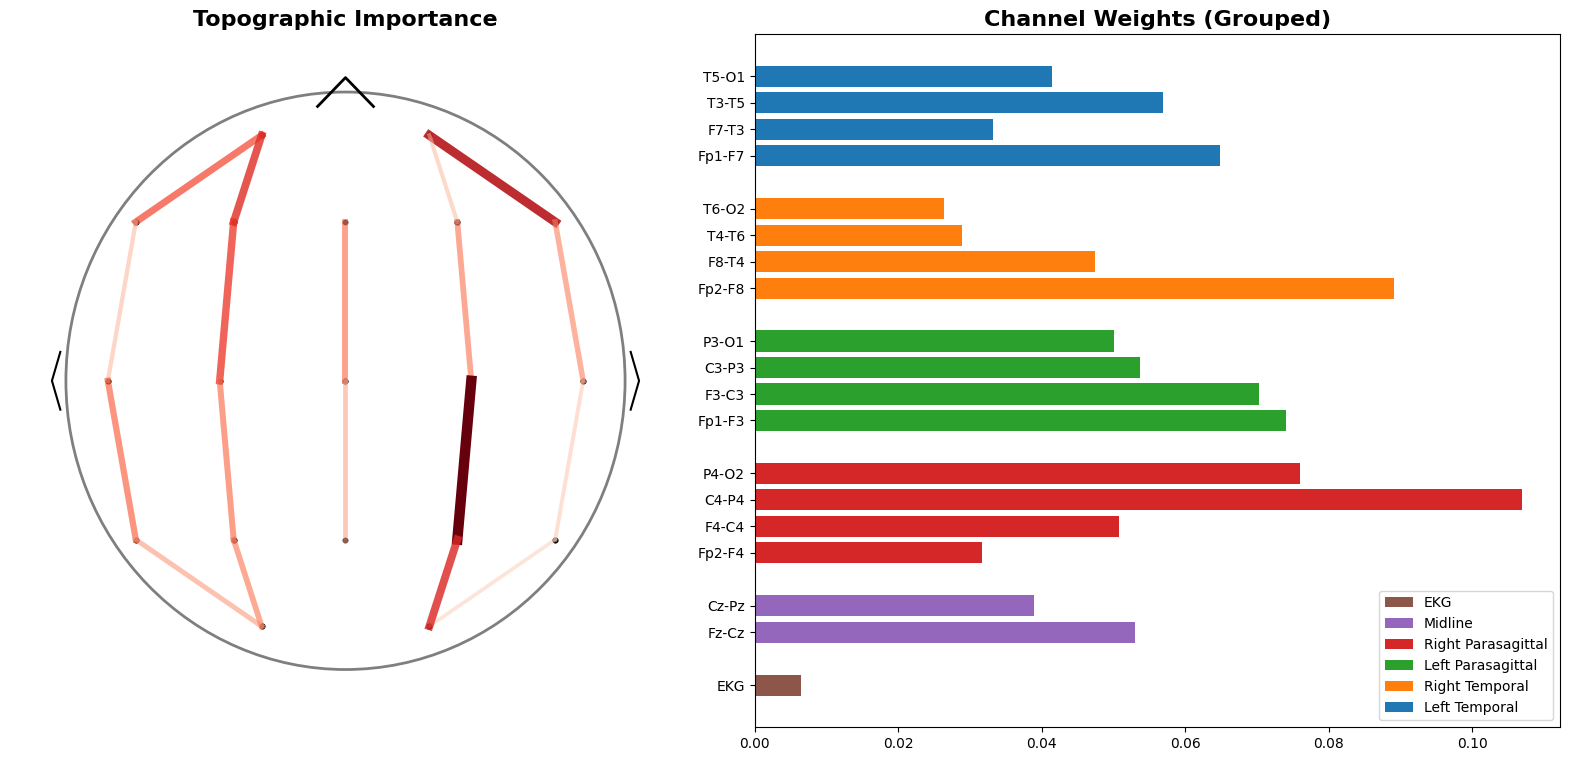

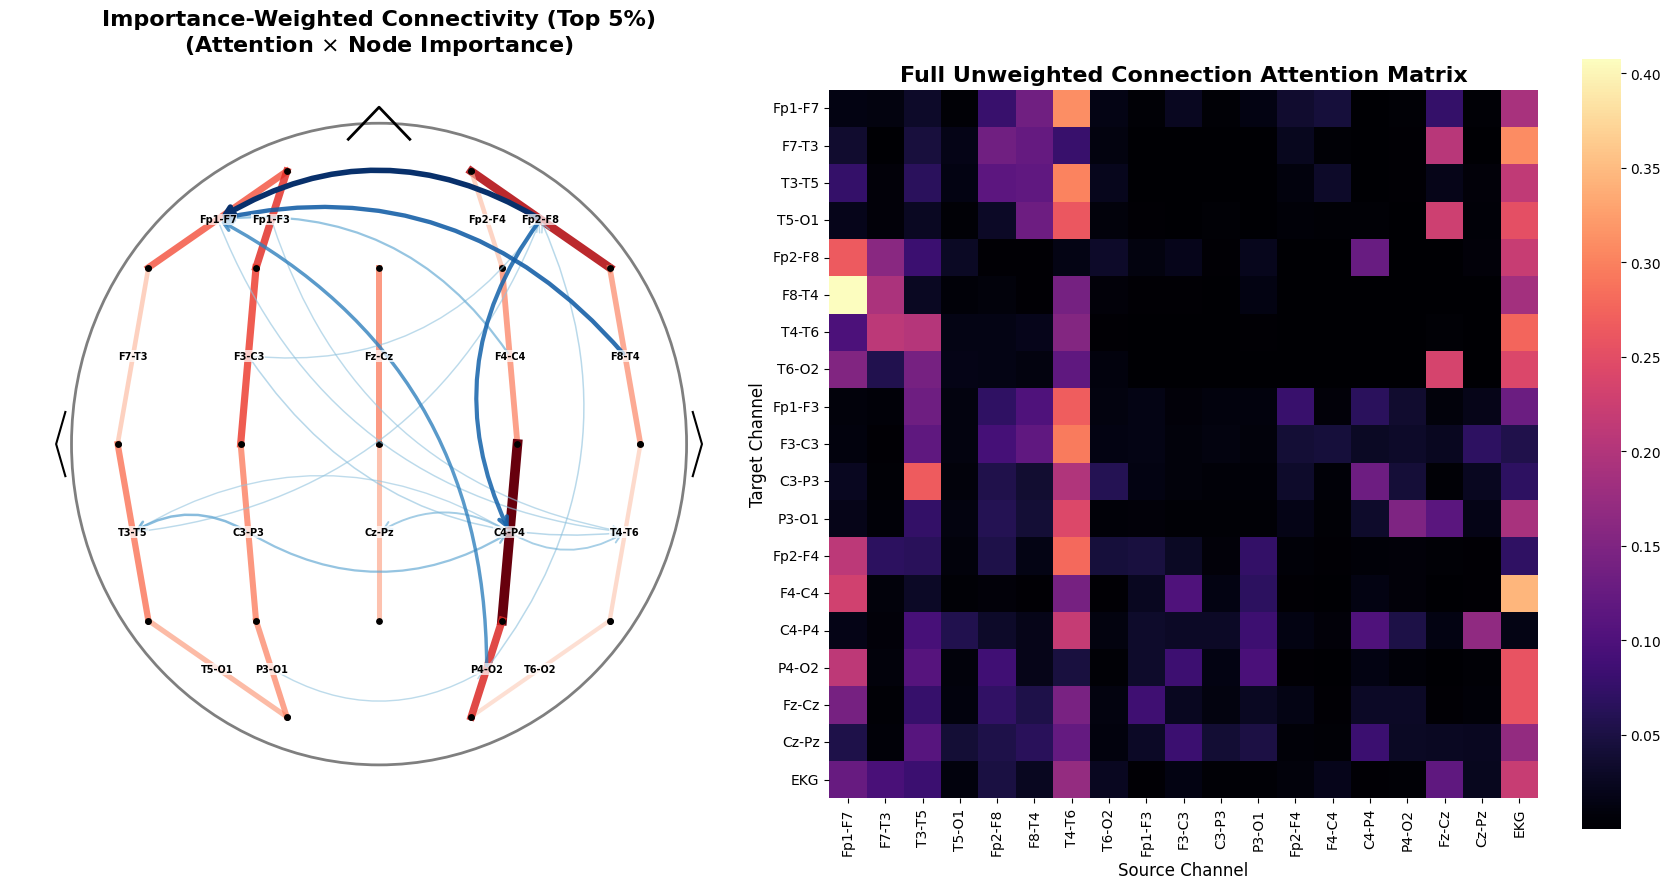

   [WORST] Index 2518 | KLD: 1.7604


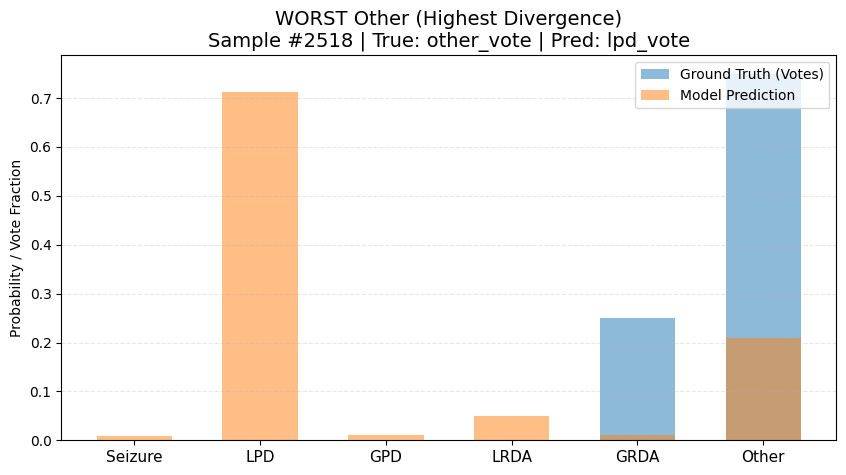

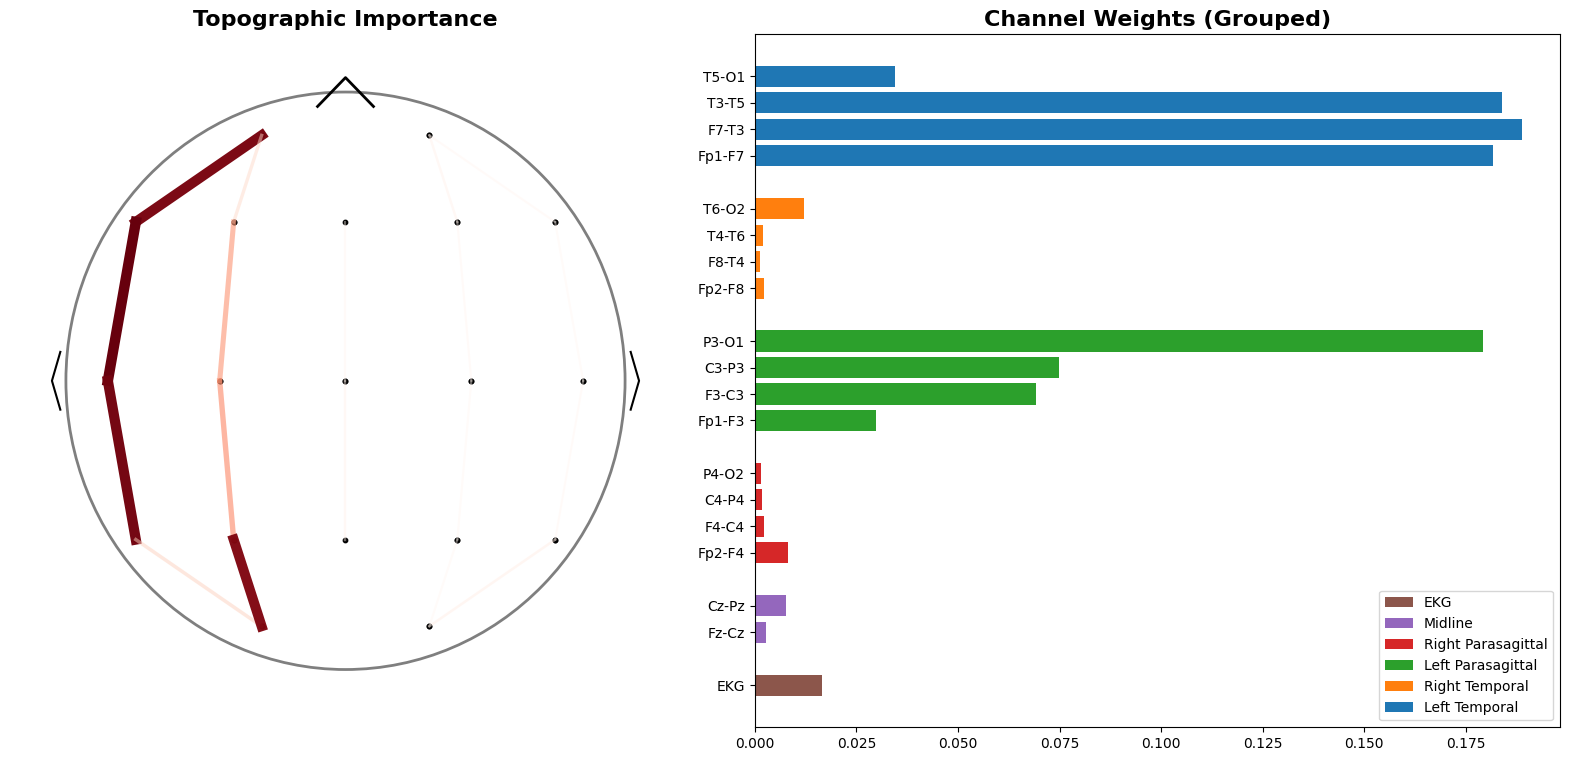

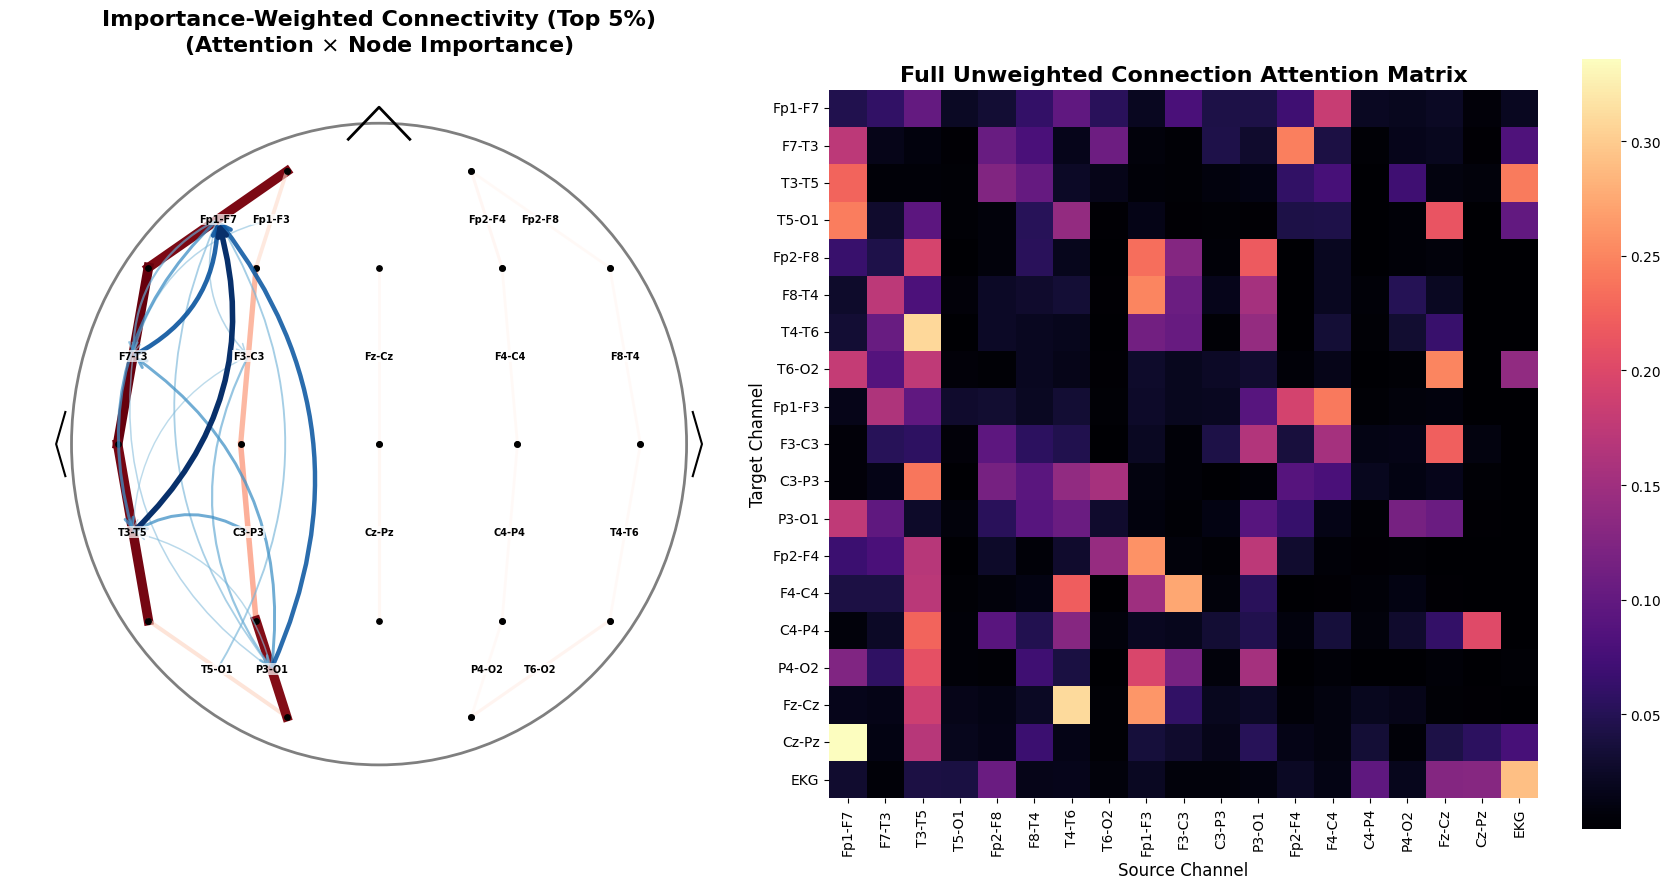

/tmp/ipykernel_139920/55461792.py:264: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clean_df, x='expert_consensus', y='kld_score', palette="viridis")


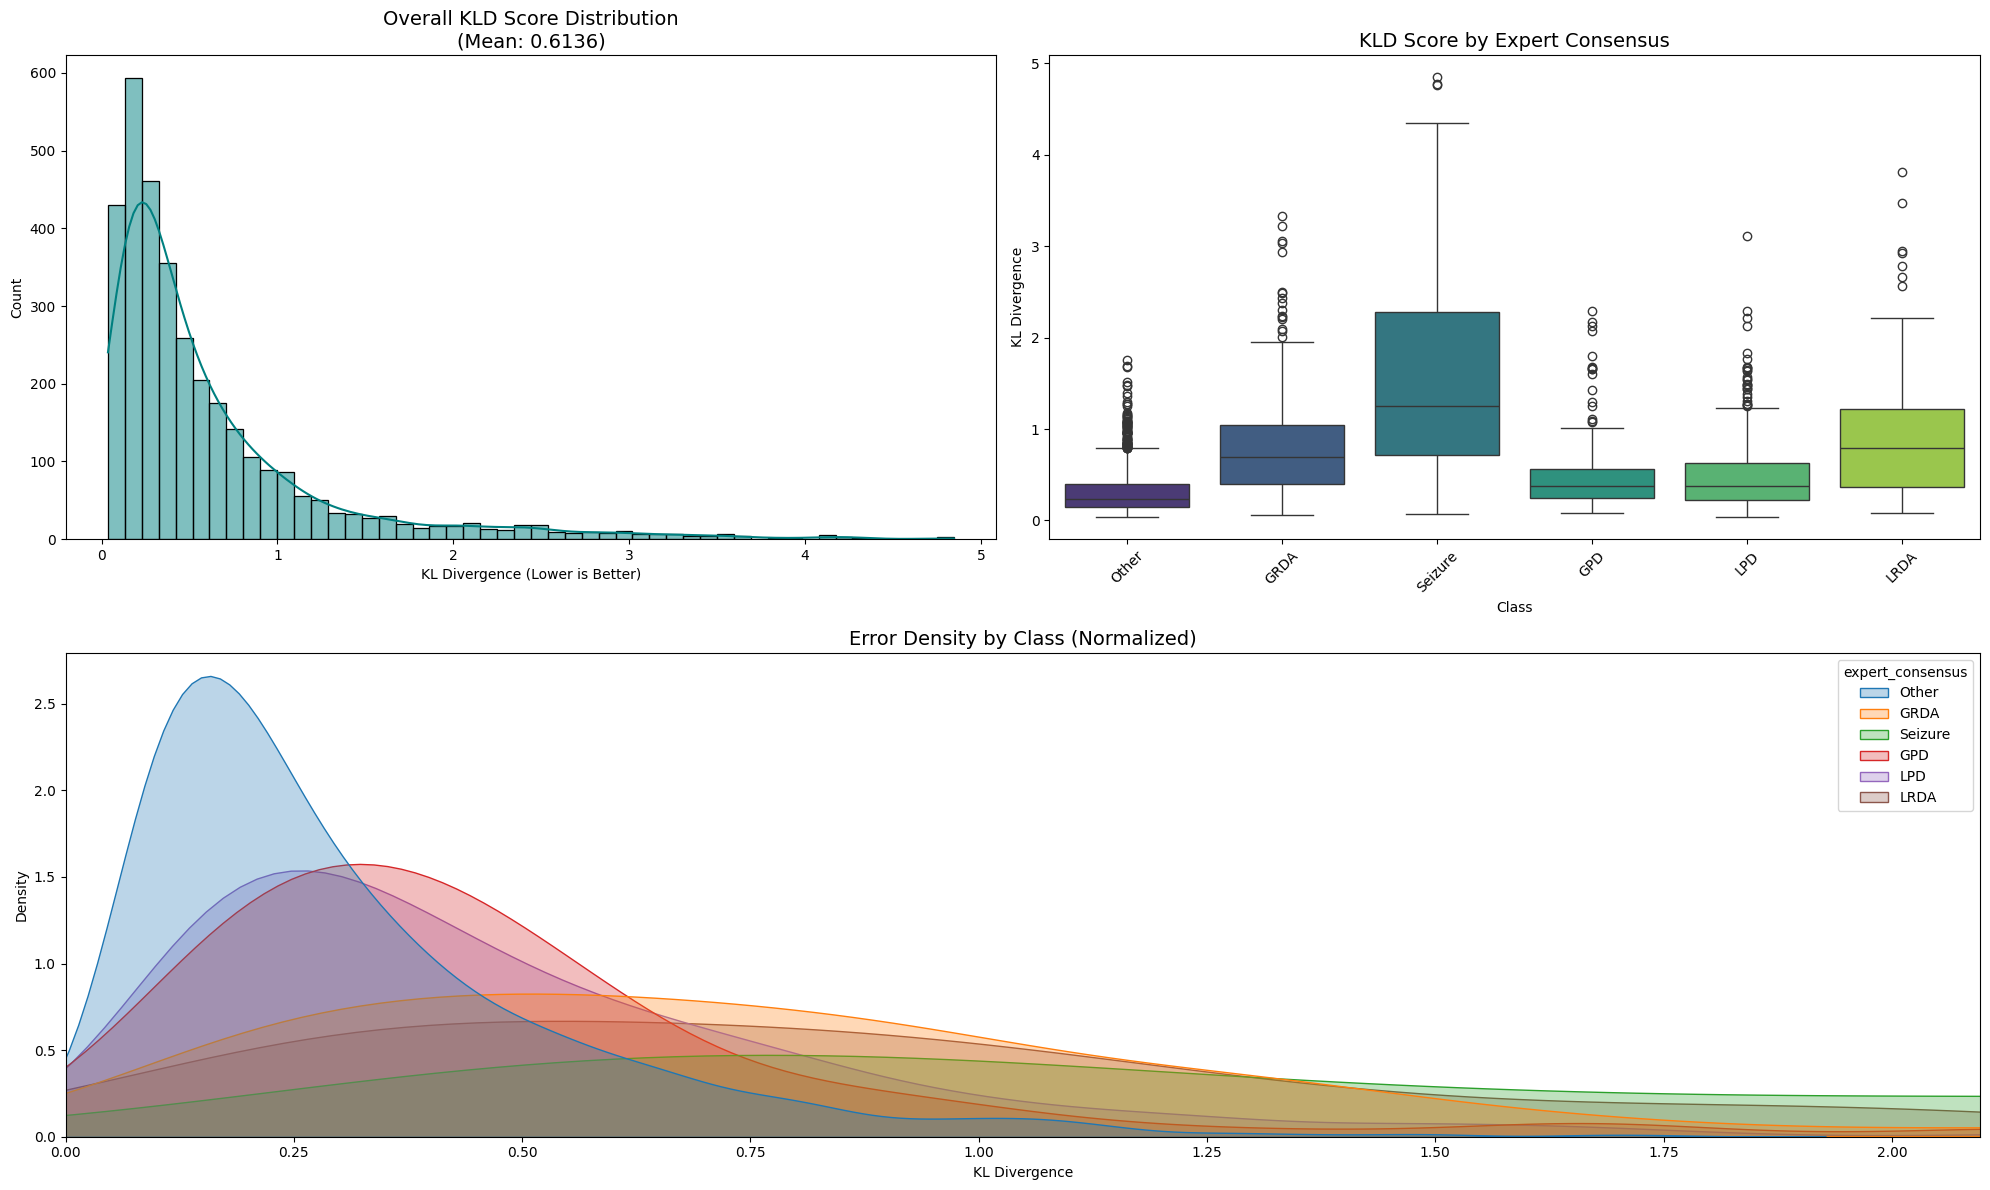


Summary Statistics by Class:
                   count      mean       std       max
expert_consensus                                      
Seizure            496.0  1.533005  1.025958  4.846923
LRDA               156.0  0.947814  0.706294  3.813641
GRDA               368.0  0.795840  0.556893  3.325632
LPD                583.0  0.483482  0.374138  3.109694
GPD                229.0  0.482008  0.387432  2.292549
Other             1549.0  0.310643  0.242640  1.760405
Generating Confusion Matrix on 3381 samples...


Running Inference:   0%|          | 0/106 [00:00<?, ?it/s]

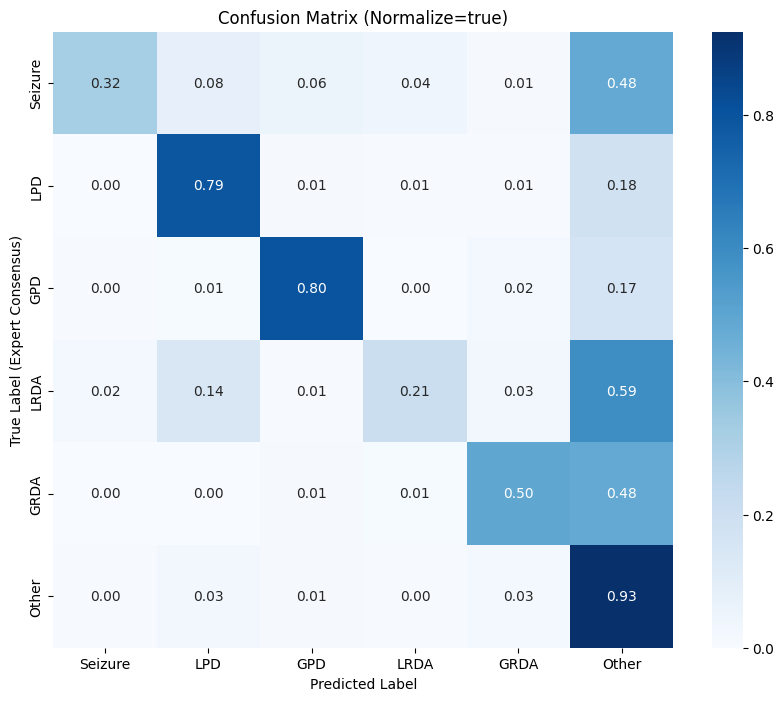

Running Inference for Soft Analysis...


  0%|          | 0/106 [00:00<?, ?it/s]

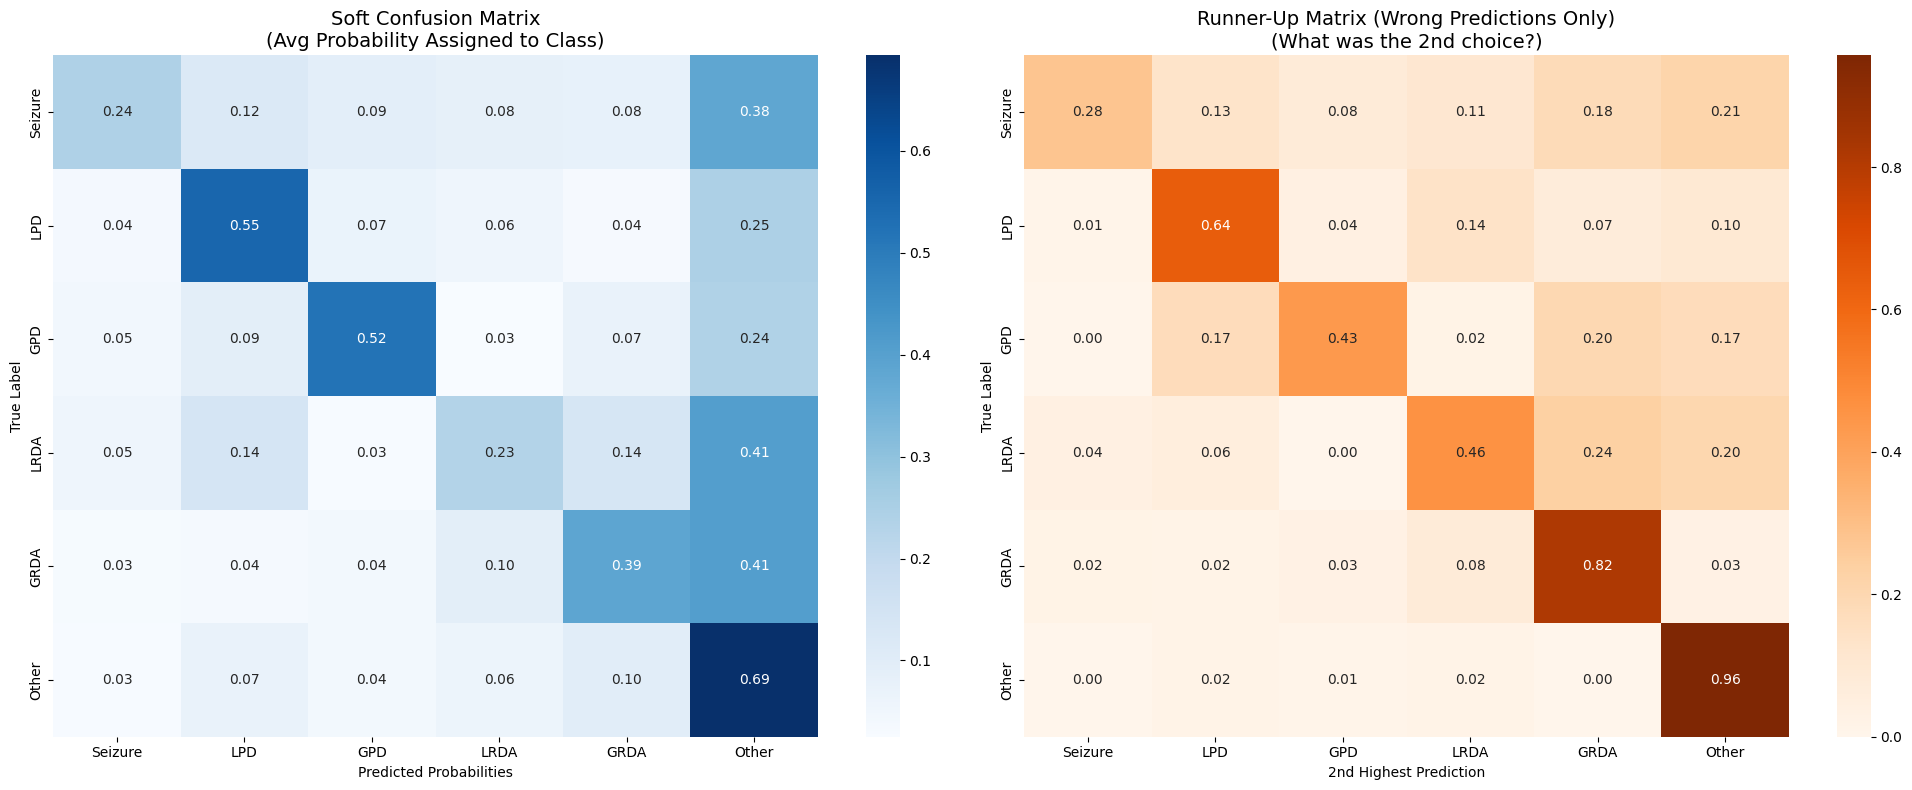

Top-1 Accuracy: 0.7252
Top-2 Accuracy: 0.8767 (Probability that correct label was in top 2 guesses)


In [4]:

DATA_PREPARATION_VOTE_METHOD = "max_vote_window"
processed_data_path = os.path.join(CFG.data_path, f'processed_data_{DATA_PREPARATION_VOTE_METHOD}.csv')

if os.path.exists(processed_data_path):
    print(f"Loading data from {processed_data_path}...")
    df = pd.read_csv(processed_data_path)
    
    if 'expert_consensus' not in df.columns:
        df['expert_consensus'] = df[TARGETS].idxmax(axis=1)

    print("Creating folds...")
    fold_creator = KFoldCreator(n_splits=CFG.n_splits, seed=CFG.seed)
    df = fold_creator.create_folds(df, stratify_col='expert_consensus', group_col='patient_id')

    model = NodeAttentionModel(
        num_nodes=CFG.num_channels, node_embed_size=256, hidden_size=CFG.hidden_units,     
        num_layers=CFG.num_layers, num_classes=CFG.target_size, num_cnn_blocks=CFG.num_cnn_blocks,
        dropout=CFG.dropout, use_inception=True              
    )
    
    FOLD_TO_ANALYZE = 2
    weights_path = get_models_save_path() / "GRUConvNodeAttentionModel" / DATA_PREPARATION_VOTE_METHOD / f'best_model_fold{FOLD_TO_ANALYZE}.pth'

    if os.path.exists(weights_path):
        print(f"Loading weights from {weights_path}...")
        model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
        model.to(DEVICE)
        
        valid_df = df[df['fold'] == FOLD_TO_ANALYZE].reset_index(drop=True)
        valid_dataset = EEGDatasetMontage(
            df=valid_df, data_path=CFG.data_path, mode='valid', 
            downsample_factor=CFG.downsample_factor
        )
        
        valid_loader = DataLoader(
            valid_dataset, batch_size=CFG.batch_size, shuffle=False, 
            num_workers=CFG.num_workers, drop_last=False
        )
        
        print(f"\nRunning Inference on {len(valid_dataset)} samples to calculate KLD scores...")
        
        all_kld_scores = []
        all_indices = []
        model.eval()
        
        with torch.no_grad():
            for i, (signals, labels) in enumerate(tqdm(valid_loader)):
                signals = signals.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(signals)
                
                log_probs = F.log_softmax(outputs, dim=1)
                
                batch_kld = F.kl_div(log_probs, labels, reduction='none').sum(dim=1)
                
                all_kld_scores.extend(batch_kld.cpu().numpy())
                
                start_idx = i * CFG.batch_size
                batch_indices = list(range(start_idx, start_idx + len(signals)))
                all_indices.extend(batch_indices)

        analysis_df = valid_df.copy()
        analysis_df['kld_score'] = np.nan
        analysis_df.loc[all_indices, 'kld_score'] = all_kld_scores
        
        target_map = {
            "seizure_vote": "Seizure", "lpd_vote": "LPD", "gpd_vote": "GPD",
            "lrda_vote": "LRDA", "grda_vote": "GRDA", "other_vote": "Other"
        }
        
        print("\n" + "="*50)
        print("VISUALIZING BEST (LOWEST KLD) AND WORST (HIGHEST KLD) SAMPLES")
        print("="*50)

        for target_col in TARGETS:
            consensus_label = target_map.get(target_col, target_col)
            
            class_df = analysis_df[analysis_df['expert_consensus'] == consensus_label]
            
            if len(class_df) == 0:
                class_df = analysis_df[analysis_df['expert_consensus'] == target_col]
            
            print(f"\n---> Analyzing Class: {consensus_label}")
            if len(class_df) == 0:
                print("No samples found.")
                continue
                
            best_row = class_df.nsmallest(1, 'kld_score').iloc[0]
            best_idx = best_row.name 
            
            worst_row = class_df.nlargest(1, 'kld_score').iloc[0]
            worst_idx = worst_row.name
            
            print(f"   [BEST] Index {best_idx} | KLD: {best_row['kld_score']:.4f}")
            interpret_sample(model, valid_dataset, sample_index=best_idx, 
                             title_prefix=f"BEST {consensus_label} (Lowest Divergence)")
            
            print(f"   [WORST] Index {worst_idx} | KLD: {worst_row['kld_score']:.4f}")
            interpret_sample(model, valid_dataset, sample_index=worst_idx, 
                             title_prefix=f"WORST {consensus_label} (Highest Divergence)")
            

        plot_kld_distribution(analysis_df)
        
        plot_soft_target_confusion_matrix(model, valid_dataset, DEVICE, normalize='true')
        
        analyze_soft_predictions(model, valid_dataset, DEVICE)

    else:
        print(f"Weights file not found: {weights_path}")
else:
    print(f"Data file not found: {processed_data_path}")